**Attack**

Epoch 1/20
244/244 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - accuracy: 0.4184 - loss: 1.0660
Epoch 2/20
244/244 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.4994 - loss: 0.9782
Epoch 3/20
244/244 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.5365 - loss: 0.9037
Epoch 4/20
244/244 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.5762 - loss: 0.8476
Epoch 5/20
244/244 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6123 - loss: 0.7839
Epoch 6/20
244/244 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6253 - loss: 0.7571
Epoch 7/20
244/244 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6391 - loss: 0.7247
Epoch 8/20
244/244 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6424 - loss: 0.7101
Epoch 9/20
244/244 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6555 - loss: 0.6865
Epoch 10/20
244/244 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6674 - loss: 0.6701
Epoch 11/20
244/244 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6719 - loss: 0.6545
Epoch 12/20
244/244 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step

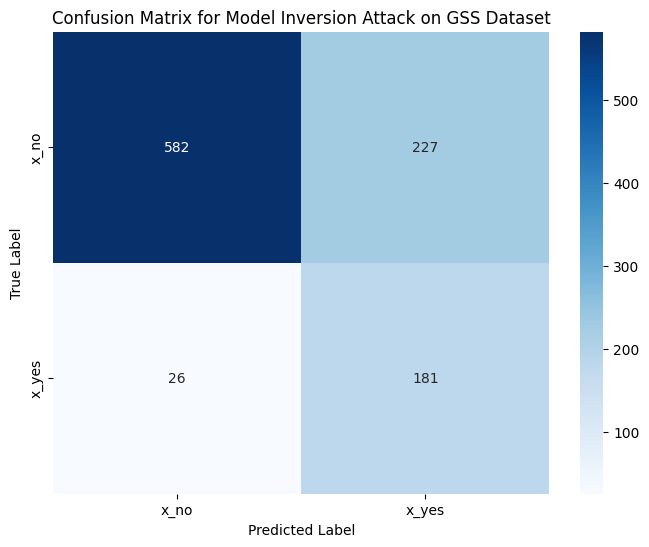

Classification Report:
               precision    recall  f1-score   support

        x_no       0.96      0.72      0.82       809
       x_yes       0.44      0.87      0.59       207

    accuracy                           0.75      1016
   macro avg       0.70      0.80      0.71      1016
weighted avg       0.85      0.75      0.77      1016



In [17]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.utils.class_weight import compute_class_weight
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras import layers, models
from tensorflow.keras.optimizers import Adam

file_path = 'GSS_5079.csv'
gss_data = pd.read_csv(file_path)

X = gss_data[['marital', 'divorce', 'childs', 'age', 'educ', 'sex', 'race', 'relig', 'pornlaw']]
sensitive_feature = gss_data['xmovie']
y = gss_data['hapmar']

cat_features = ['marital', 'divorce', 'sex', 'race', 'relig', 'pornlaw']
num_features = ['childs', 'age', 'educ']
preprocessor = ColumnTransformer([
    ('num', StandardScaler(), num_features),
    ('cat', OneHotEncoder(handle_unknown='ignore'), cat_features)
])

X_preprocessed = preprocessor.fit_transform(X).toarray()


sensitive_encoder = OneHotEncoder(sparse_output=False)
sensitive_feature_encoded = sensitive_encoder.fit_transform(sensitive_feature.values.reshape(-1, 1))


target_encoder = OneHotEncoder(sparse_output=False)
y_encoded = target_encoder.fit_transform(y.values.reshape(-1, 1))


X_train, X_test, y_train, y_test, sensitive_train, sensitive_test = train_test_split(
    X_preprocessed, y_encoded, sensitive_feature_encoded, test_size=0.2, random_state=42
)

# Apply SMOTE for oversampling the minority class
smote = SMOTE(random_state=42)
X_train, y_train = smote.fit_resample(X_train, y_train)

# Compute class weights to balance dataset
class_weights = compute_class_weight('balanced', classes=np.unique(np.argmax(sensitive_train, axis=1)), y=np.argmax(sensitive_train, axis=1))
class_weights_dict = {i: class_weights[i] for i in range(len(class_weights))}

# Define the target model
input_dim = X_train.shape[1]
target_model = models.Sequential([
    layers.Input(shape=(input_dim,)),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.2),
    layers.Dense(64, activation='relu'),
    layers.Dense(32, activation='relu'),
    layers.Dense(y_encoded.shape[1], activation='softmax')
])

target_model.compile(optimizer=Adam(learning_rate=0.001),
                     loss='categorical_crossentropy',
                     metrics=['accuracy'])


target_model.fit(X_train, y_train, epochs=20, batch_size=32, verbose=1)


test_loss, test_accuracy = target_model.evaluate(X_test, y_test, verbose=1)
print(f"Target Model - Test Loss: {test_loss:.2f}, Test Accuracy: {test_accuracy:.2f}")

# BLACK-BOX MODEL INVERSION ATTACK --
# Step 1: Query the target model to get its predictions
predicted_probabilities = target_model.predict(X_test)

# Step 2: Train the inversion model
X_inversion = np.hstack((X_test, predicted_probabilities.reshape(-1, predicted_probabilities.shape[1])))
y_inversion = sensitive_test  # The actual sensitive attributes

# Define the inversion model
inversion_model = models.Sequential([
    layers.Input(shape=(X_inversion.shape[1],)),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.2),
    layers.Dense(64, activation='relu'),
    layers.Dense(32, activation='relu'),
    layers.Dense(sensitive_test.shape[1], activation='softmax')
])

inversion_model.compile(optimizer=Adam(learning_rate=0.001),
                        loss='categorical_crossentropy',
                        metrics=['accuracy'])


inversion_model.fit(X_inversion, y_inversion, epochs=20, batch_size=32, verbose=1, class_weight=class_weights_dict)

# Evaluate the inversion model
sensitive_pred = inversion_model.predict(X_inversion)
threshold = 0.6
sensitive_pred_labels = (sensitive_pred[:, 1] > threshold).astype(int)
sensitive_true_labels = np.argmax(y_inversion, axis=1)
inversion_accuracy = accuracy_score(sensitive_true_labels, sensitive_pred_labels)
print(f"Inversion Model - Accuracy: {inversion_accuracy:.2f}")


conf_matrix = confusion_matrix(sensitive_true_labels, sensitive_pred_labels)


class_report = classification_report(sensitive_true_labels, sensitive_pred_labels, target_names=sensitive_encoder.categories_[0])


plt.figure(figsize=(8,6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=sensitive_encoder.categories_[0], yticklabels=sensitive_encoder.categories_[0])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix for Model Inversion Attack on GSS Dataset")
plt.show()


print("Classification Report:\n", class_report)


Implemented the following defense mechanisms:
1. Differential Privacy
2. Adversarial Training
3. Feature Suppression

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Shape of X_test: (1016, 32)
Shape of predicted_probabilities: (1016, 3)
Shape of X_inversion (Final Input to Inversion Model): (1016, 35)
Shape of sensitive_test (Labels for Inversion Model): (1016, 2)
Epoch 1/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.4945 - loss: 0.7101
Epoch 2/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6440 - loss: 0.6226
Epoch 3/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6371 - loss: 0.6060
Epoch 4/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6349 - loss: 0.6133
Epoch 5/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6838 - loss: 0.5690
Epoch 6/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6898 - loss: 0.5391
Epoch 7/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6804 - loss: 0.5426
Epoch 8/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7039 - loss: 0.5459
Epoch 9/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7144 - loss: 0.5458
Epo

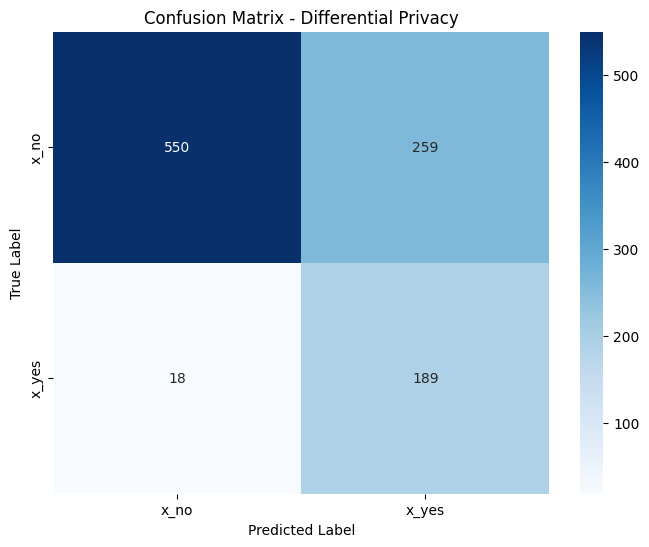


Defense Mechanism: Adversarial Training
Inversion Model Accuracy: 0.75
Classification Report:
               precision    recall  f1-score   support

        x_no       0.96      0.72      0.82       809
       x_yes       0.44      0.89      0.59       207

    accuracy                           0.75      1016
   macro avg       0.70      0.80      0.71      1016
weighted avg       0.86      0.75      0.77      1016



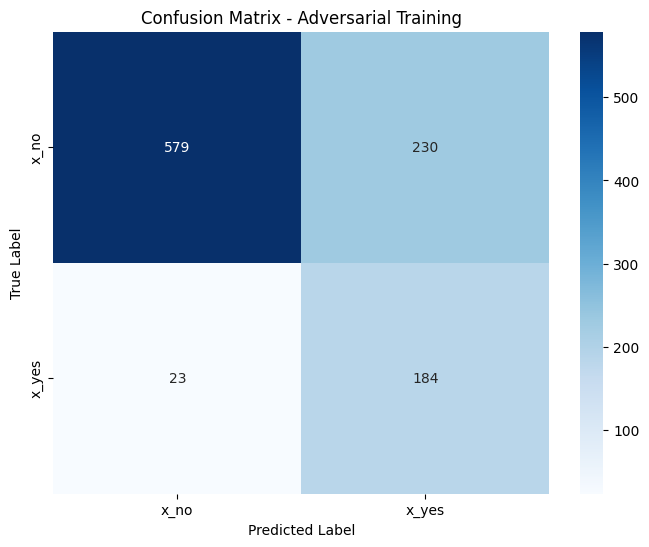


Defense Mechanism: Feature Suppression
Inversion Model Accuracy: 0.74
Classification Report:
               precision    recall  f1-score   support

        x_no       0.96      0.70      0.81       809
       x_yes       0.43      0.89      0.58       207

    accuracy                           0.74      1016
   macro avg       0.69      0.79      0.69      1016
weighted avg       0.85      0.74      0.76      1016



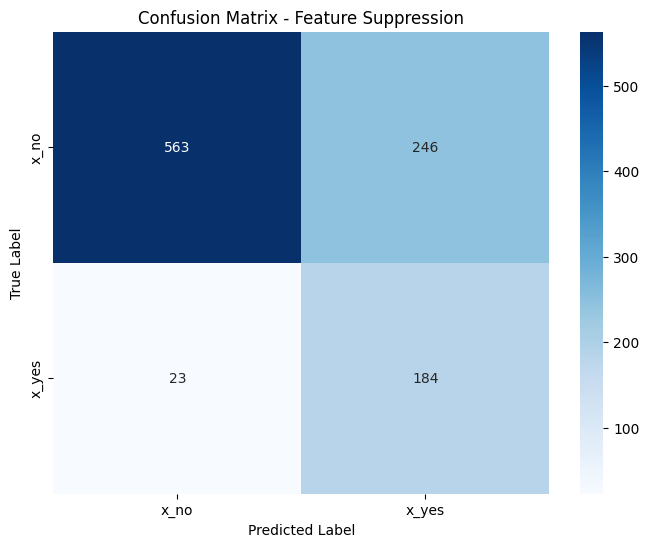

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.utils.class_weight import compute_class_weight
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.optimizers import Adam

# Load dataset
file_path = 'GSS_5079.csv'  # Update with your actual file path
gss_data = pd.read_csv(file_path)

# Select features and target
X = gss_data[['marital', 'divorce', 'childs', 'age', 'educ', 'sex', 'race', 'relig', 'pornlaw']]
sensitive_feature = gss_data['xmovie']
y = gss_data['hapmar']

# Preprocessing
cat_features = ['marital', 'divorce', 'sex', 'race', 'relig', 'pornlaw']
num_features = ['childs', 'age', 'educ']
preprocessor = ColumnTransformer([
    ('num', StandardScaler(), num_features),
    ('cat', OneHotEncoder(handle_unknown='ignore'), cat_features)
])

X_preprocessed = preprocessor.fit_transform(X).toarray()

sensitive_encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
sensitive_feature_encoded = sensitive_encoder.fit_transform(sensitive_feature.values.reshape(-1, 1))

target_encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
y_encoded = target_encoder.fit_transform(y.values.reshape(-1, 1))

X_train, X_test, y_train, y_test, sensitive_train, sensitive_test = train_test_split(
    X_preprocessed, y_encoded, sensitive_feature_encoded, test_size=0.2, random_state=42
)

# Compute class weights
class_weights = compute_class_weight('balanced', classes=np.unique(np.argmax(sensitive_train, axis=1)), y=np.argmax(sensitive_train, axis=1))
class_weights_dict = {i: class_weights[i] for i in range(len(class_weights))}

# Define defense mechanisms
def add_differential_privacy_noise(data, epsilon=1.0):
    noise = np.random.laplace(0, 1/epsilon, data.shape)
    return data + noise

def apply_adversarial_training(X_train, y_train, epsilon=0.01):
    X_adv = X_train + epsilon * np.sign(np.random.randn(*X_train.shape))
    return np.vstack([X_train, X_adv]), np.vstack([y_train, y_train])

def feature_suppression(data, sensitive_columns):
    data[:, sensitive_columns] = 0
    return data

def train_target_model(X_train, y_train):
    input_dim = X_train.shape[1]
    model = models.Sequential([
        layers.Input(shape=(input_dim,)),
        layers.Dense(128, activation='relu'),
        layers.Dropout(0.2),
        layers.Dense(64, activation='relu'),
        layers.Dense(32, activation='relu'),
        layers.Dense(y_encoded.shape[1], activation='softmax')
    ])

    model.compile(optimizer=Adam(learning_rate=0.001),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

    model.fit(X_train, y_train, epochs=20, batch_size=32, verbose=1)
    return model

def evaluate_inversion_model(inversion_model, X_test, sensitive_test, target_model):
    predicted_probabilities = target_model.predict(X_test)
    X_inversion = np.hstack((X_test, predicted_probabilities))

    # Debugging prints
    print("Using X_inversion for evaluation")
    print("Shape of X_inversion:", X_inversion.shape)

    sensitive_pred = inversion_model.predict(X_inversion)
    sensitive_true_labels = np.argmax(sensitive_test, axis=1)
    sensitive_pred_labels = np.argmax(sensitive_pred, axis=1)

    accuracy = accuracy_score(sensitive_true_labels, sensitive_pred_labels)
    conf_matrix = confusion_matrix(sensitive_true_labels, sensitive_pred_labels)
    class_report = classification_report(sensitive_true_labels, sensitive_pred_labels, target_names=sensitive_encoder.categories_[0])

    return accuracy, conf_matrix, class_report

def display_results(results):
    for defense, (accuracy, conf_matrix, class_report) in results.items():
        print(f"\nDefense Mechanism: {defense}")
        print(f"Inversion Model Accuracy: {accuracy:.2f}")
        print("Classification Report:\n", class_report)
        plt.figure(figsize=(8,6))
        sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=sensitive_encoder.categories_[0], yticklabels=sensitive_encoder.categories_[0])
        plt.xlabel("Predicted Label")
        plt.ylabel("True Label")
        plt.title(f"Confusion Matrix - {defense}")
        plt.show()

# Train inversion models
inversion_model_dp = train_inversion_model(target_model_dp, X_test, sensitive_test)
inversion_model_adv = train_inversion_model(target_model_adv, X_test, sensitive_test)
inversion_model_suppressed = train_inversion_model(target_model_suppressed, X_test, sensitive_test)

# Evaluate results
results = {
    "Differential Privacy": evaluate_inversion_model(inversion_model_dp, X_test, sensitive_test, target_model_dp),
    "Adversarial Training": evaluate_inversion_model(inversion_model_adv, X_test, sensitive_test, target_model_adv),
    "Feature Suppression": evaluate_inversion_model(inversion_model_suppressed, X_test, sensitive_test, target_model_suppressed)
}

# Display results
display_results(results)


**Testing with more stronger feature suppression, differential privacy, and gradient regularization**

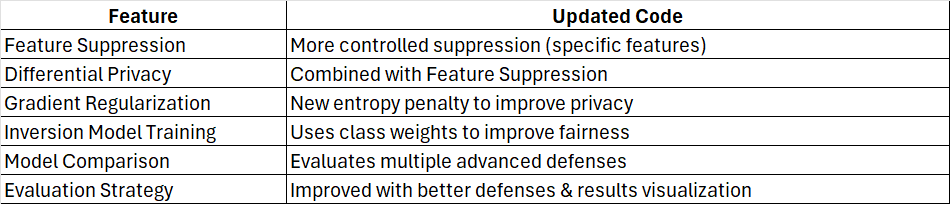

Epoch 1/20
127/127 ━━━━━━━━━━━━━━━━━━━━ 8s 8ms/step - accuracy: 0.5565 - loss: 0.8723
Epoch 2/20
127/127 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.6470 - loss: 0.7437
Epoch 3/20
127/127 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.6393 - loss: 0.7319
Epoch 4/20
127/127 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.6415 - loss: 0.7170
Epoch 5/20
127/127 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6486 - loss: 0.7104
Epoch 6/20
127/127 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6518 - loss: 0.7047
Epoch 7/20
127/127 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6637 - loss: 0.6770
Epoch 8/20
127/127 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6676 - loss: 0.6715
Epoch 9/20
127/127 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6966 - loss: 0.6483
Epoch 10/20
127/127 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6838 - loss: 0.6444
Epoch 11/20
127/127 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7090 - loss: 0.6132
Epoch 12/20
127/127 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step

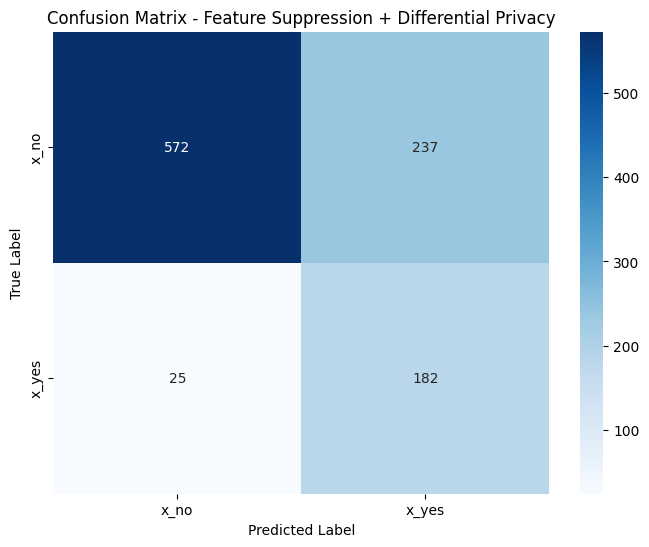


Defense Mechanism: Gradient Regularization
Inversion Model Accuracy: 0.76
Classification Report:
               precision    recall  f1-score   support

        x_no       0.97      0.72      0.83       809
       x_yes       0.45      0.91      0.61       207

    accuracy                           0.76      1016
   macro avg       0.71      0.81      0.72      1016
weighted avg       0.86      0.76      0.78      1016



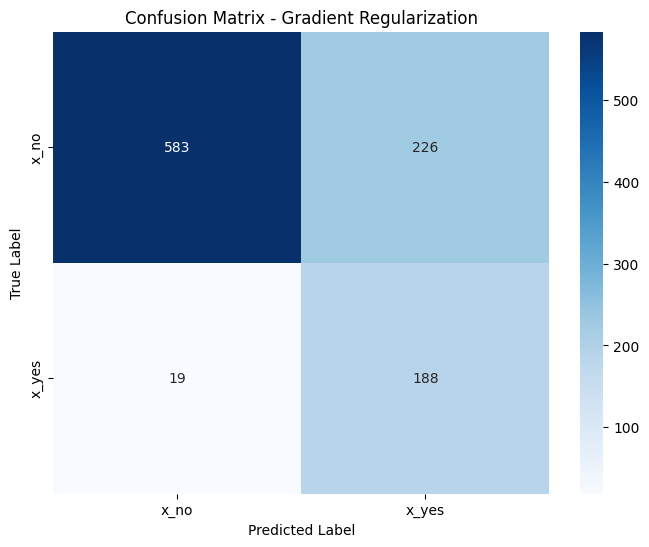

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.utils.class_weight import compute_class_weight
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.optimizers import Adam

# Load dataset
file_path = 'GSS_5079.csv'  # Update with your actual file path
gss_data = pd.read_csv(file_path)

# Select features and target
X = gss_data[['marital', 'divorce', 'childs', 'age', 'educ', 'sex', 'race', 'relig', 'pornlaw']]
sensitive_feature = gss_data['xmovie']
y = gss_data['hapmar']

# Preprocessing
cat_features = ['marital', 'divorce', 'sex', 'race', 'relig', 'pornlaw']
num_features = ['childs', 'age', 'educ']
preprocessor = ColumnTransformer([
    ('num', StandardScaler(), num_features),
    ('cat', OneHotEncoder(handle_unknown='ignore'), cat_features)
])

X_preprocessed = preprocessor.fit_transform(X).toarray()

sensitive_encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
sensitive_feature_encoded = sensitive_encoder.fit_transform(sensitive_feature.values.reshape(-1, 1))

target_encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
y_encoded = target_encoder.fit_transform(y.values.reshape(-1, 1))

X_train, X_test, y_train, y_test, sensitive_train, sensitive_test = train_test_split(
    X_preprocessed, y_encoded, sensitive_feature_encoded, test_size=0.2, random_state=42
)

# Compute class weights
class_weights = compute_class_weight('balanced', classes=np.unique(np.argmax(sensitive_train, axis=1)), y=np.argmax(sensitive_train, axis=1))
class_weights_dict = {i: class_weights[i] for i in range(len(class_weights))}

# Define defense mechanisms
def add_differential_privacy_noise(data, epsilon=1.0):
    noise = np.random.laplace(0, 1/epsilon, data.shape)
    return data + noise

def apply_adversarial_training(X_train, y_train, epsilon=0.01):
    X_adv = X_train + epsilon * np.sign(np.random.randn(*X_train.shape))
    return np.vstack([X_train, X_adv]), np.vstack([y_train, y_train])

def feature_suppression(data, sensitive_columns):
    data[:, sensitive_columns] = 0
    return data

def regularized_loss(y_true, y_pred):
    cross_entropy = tf.keras.losses.categorical_crossentropy(y_true, y_pred)
    entropy_penalty = tf.reduce_mean(-tf.reduce_sum(y_pred * tf.math.log(y_pred + 1e-10), axis=1))
    return cross_entropy + 0.1 * entropy_penalty

def train_target_model(X_train, y_train, loss_function='categorical_crossentropy'):
    input_dim = X_train.shape[1]
    model = models.Sequential([
        layers.Input(shape=(input_dim,)),
        layers.Dense(128, activation='relu'),
        layers.Dropout(0.2),
        layers.Dense(64, activation='relu'),
        layers.Dense(32, activation='relu'),
        layers.Dense(y_encoded.shape[1], activation='softmax')
    ])

    model.compile(optimizer=Adam(learning_rate=0.001),
                  loss=loss_function,
                  metrics=['accuracy'])

    model.fit(X_train, y_train, epochs=20, batch_size=32, verbose=1)
    return model

def train_inversion_model(target_model, X_test, sensitive_test):
    predicted_probabilities = target_model.predict(X_test)
    X_inversion = np.hstack((X_test, predicted_probabilities))

    inversion_model = models.Sequential([
        layers.Input(shape=(X_inversion.shape[1],)),
        layers.Dense(128, activation='relu'),
        layers.Dropout(0.2),
        layers.Dense(64, activation='relu'),
        layers.Dense(32, activation='relu'),
        layers.Dense(sensitive_test.shape[1], activation='softmax')
    ])

    inversion_model.compile(optimizer=Adam(learning_rate=0.001),
                            loss='categorical_crossentropy',
                            metrics=['accuracy'])

    inversion_model.fit(X_inversion, sensitive_test, epochs=20, batch_size=32, verbose=1, class_weight=class_weights_dict)
    return inversion_model

def evaluate_inversion_model(inversion_model, X_test, sensitive_test, target_model):
    predicted_probabilities = target_model.predict(X_test)
    X_inversion = np.hstack((X_test, predicted_probabilities))
    sensitive_pred = inversion_model.predict(X_inversion)
    sensitive_true_labels = np.argmax(sensitive_test, axis=1)
    sensitive_pred_labels = np.argmax(sensitive_pred, axis=1)

    accuracy = accuracy_score(sensitive_true_labels, sensitive_pred_labels)
    conf_matrix = confusion_matrix(sensitive_true_labels, sensitive_pred_labels)
    class_report = classification_report(sensitive_true_labels, sensitive_pred_labels, target_names=sensitive_encoder.categories_[0])

    return accuracy, conf_matrix, class_report

# Apply enhanced defenses
X_train_suppressed = feature_suppression(X_train.copy(), sensitive_columns=[0, 1, 2, 3])
X_train_suppressed_dp = add_differential_privacy_noise(X_train_suppressed.copy(), epsilon=1.0)

target_model_suppressed_dp = train_target_model(X_train_suppressed_dp, y_train)
target_model_reg = train_target_model(X_train, y_train, loss_function=regularized_loss)

# Train inversion models
inversion_model_suppressed_dp = train_inversion_model(target_model_suppressed_dp, X_test, sensitive_test)
inversion_model_reg = train_inversion_model(target_model_reg, X_test, sensitive_test)

# Evaluate results
results = {
    "Feature Suppression + Differential Privacy": evaluate_inversion_model(inversion_model_suppressed_dp, X_test, sensitive_test, target_model_suppressed_dp),
    "Gradient Regularization": evaluate_inversion_model(inversion_model_reg, X_test, sensitive_test, target_model_reg)
}

# Display results
display_results(results)

**Add more noise by by setting epsilon = 0.5 instead of 1.0**

Epoch 1/20
127/127 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.5485 - loss: 2.4017
Epoch 2/20
127/127 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.5670 - loss: 0.9164
Epoch 3/20
127/127 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6197 - loss: 0.7955
Epoch 4/20
127/127 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6086 - loss: 0.7691
Epoch 5/20
127/127 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6255 - loss: 0.7438
Epoch 6/20
127/127 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6389 - loss: 0.7332
Epoch 7/20
127/127 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6458 - loss: 0.7341
Epoch 8/20
127/127 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6520 - loss: 0.7081
Epoch 9/20
127/127 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6465 - loss: 0.7242
Epoch 10/20
127/127 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6486 - loss: 0.7070
Epoch 11/20
127/127 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6576 - loss: 0.6933
Epoch 12/20
127/127 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step

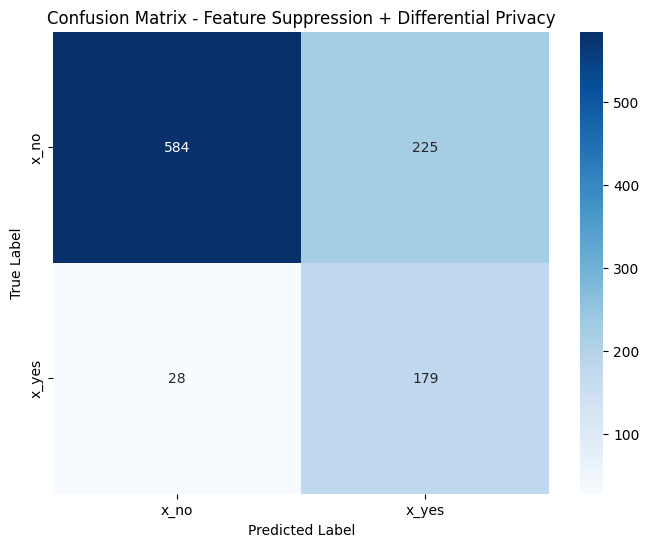


Defense Mechanism: Gradient Regularization
Inversion Model Accuracy: 0.76
Classification Report:
               precision    recall  f1-score   support

        x_no       0.95      0.73      0.83       809
       x_yes       0.45      0.86      0.60       207

    accuracy                           0.76      1016
   macro avg       0.70      0.80      0.71      1016
weighted avg       0.85      0.76      0.78      1016



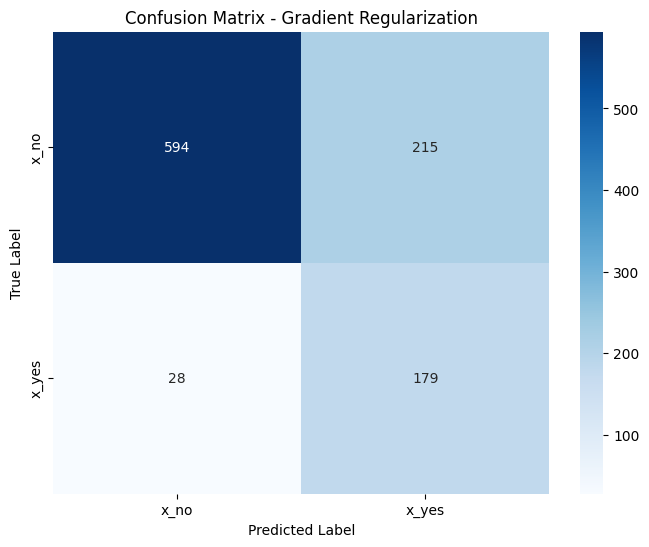

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.utils.class_weight import compute_class_weight
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.optimizers import Adam

# Load dataset
file_path = 'GSS_5079.csv'  # Update with your actual file path
gss_data = pd.read_csv(file_path)

# Select features and target
X = gss_data[['marital', 'divorce', 'childs', 'age', 'educ', 'sex', 'race', 'relig', 'pornlaw']]
sensitive_feature = gss_data['xmovie']
y = gss_data['hapmar']

# Preprocessing
cat_features = ['marital', 'divorce', 'sex', 'race', 'relig', 'pornlaw']
num_features = ['childs', 'age', 'educ']
preprocessor = ColumnTransformer([
    ('num', StandardScaler(), num_features),
    ('cat', OneHotEncoder(handle_unknown='ignore'), cat_features)
])

X_preprocessed = preprocessor.fit_transform(X).toarray()

sensitive_encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
sensitive_feature_encoded = sensitive_encoder.fit_transform(sensitive_feature.values.reshape(-1, 1))

target_encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
y_encoded = target_encoder.fit_transform(y.values.reshape(-1, 1))

X_train, X_test, y_train, y_test, sensitive_train, sensitive_test = train_test_split(
    X_preprocessed, y_encoded, sensitive_feature_encoded, test_size=0.2, random_state=42
)

# Compute class weights
class_weights = compute_class_weight('balanced', classes=np.unique(np.argmax(sensitive_train, axis=1)), y=np.argmax(sensitive_train, axis=1))
class_weights_dict = {i: class_weights[i] for i in range(len(class_weights))}

# Define defense mechanisms
def add_differential_privacy_noise(data, epsilon=0.1):
    noise = np.random.laplace(0, 1/epsilon, data.shape)
    return data + noise

def apply_adversarial_training(X_train, y_train, epsilon=0.01):
    X_adv = X_train + epsilon * np.sign(np.random.randn(*X_train.shape))
    return np.vstack([X_train, X_adv]), np.vstack([y_train, y_train])

def feature_suppression(data, sensitive_columns):
    data[:, sensitive_columns] = 0
    return data

def regularized_loss(y_true, y_pred):
    cross_entropy = tf.keras.losses.categorical_crossentropy(y_true, y_pred)
    entropy_penalty = tf.reduce_mean(-tf.reduce_sum(y_pred * tf.math.log(y_pred + 1e-10), axis=1))
    return cross_entropy + 0.1 * entropy_penalty

def train_target_model(X_train, y_train, loss_function='categorical_crossentropy'):
    input_dim = X_train.shape[1]
    model = models.Sequential([
        layers.Input(shape=(input_dim,)),
        layers.Dense(128, activation='relu'),
        layers.Dropout(0.2),
        layers.Dense(64, activation='relu'),
        layers.Dense(32, activation='relu'),
        layers.Dense(y_encoded.shape[1], activation='softmax')
    ])

    model.compile(optimizer=Adam(learning_rate=0.001),
                  loss=loss_function,
                  metrics=['accuracy'])

    model.fit(X_train, y_train, epochs=20, batch_size=32, verbose=1)
    return model

def train_inversion_model(target_model, X_test, sensitive_test):
    predicted_probabilities = target_model.predict(X_test)
    X_inversion = np.hstack((X_test, predicted_probabilities))

    inversion_model = models.Sequential([
        layers.Input(shape=(X_inversion.shape[1],)),
        layers.Dense(128, activation='relu'),
        layers.Dropout(0.2),
        layers.Dense(64, activation='relu'),
        layers.Dense(32, activation='relu'),
        layers.Dense(sensitive_test.shape[1], activation='softmax')
    ])

    inversion_model.compile(optimizer=Adam(learning_rate=0.001),
                            loss='categorical_crossentropy',
                            metrics=['accuracy'])

    inversion_model.fit(X_inversion, sensitive_test, epochs=20, batch_size=32, verbose=1, class_weight=class_weights_dict)
    return inversion_model

def evaluate_inversion_model(inversion_model, X_test, sensitive_test, target_model):
    def mask_confidences(y_pred, bins=10):
        return tf.round(y_pred * bins) / bins  # Round probabilities to nearest 0.1

    predicted_probabilities = target_model.predict(X_test)
    predicted_probabilities = mask_confidences(predicted_probabilities)  # Apply confidence masking
    X_inversion = np.hstack((X_test, predicted_probabilities))
    predicted_probabilities = target_model.predict(X_test)
    X_inversion = np.hstack((X_test, predicted_probabilities))
    sensitive_pred = inversion_model.predict(X_inversion)
    sensitive_true_labels = np.argmax(sensitive_test, axis=1)
    sensitive_pred_labels = np.argmax(sensitive_pred, axis=1)

    accuracy = accuracy_score(sensitive_true_labels, sensitive_pred_labels)
    conf_matrix = confusion_matrix(sensitive_true_labels, sensitive_pred_labels)
    class_report = classification_report(sensitive_true_labels, sensitive_pred_labels, target_names=sensitive_encoder.categories_[0])

    return accuracy, conf_matrix, class_report

# Apply enhanced defenses
X_train_suppressed = feature_suppression(X_train.copy(), sensitive_columns=[0, 1, 2, 3])
X_train_suppressed_dp = add_differential_privacy_noise(X_train_suppressed.copy(), epsilon=0.1)

target_model_suppressed_dp = train_target_model(X_train_suppressed_dp, y_train)
target_model_reg = train_target_model(X_train, y_train, loss_function=regularized_loss)

# Train inversion models
inversion_model_suppressed_dp = train_inversion_model(target_model_suppressed_dp, X_test, sensitive_test)
inversion_model_reg = train_inversion_model(target_model_reg, X_test, sensitive_test)

# Evaluate results
results = {
    "Feature Suppression + Differential Privacy": evaluate_inversion_model(inversion_model_suppressed_dp, X_test, sensitive_test, target_model_suppressed_dp),
    "Gradient Regularization": evaluate_inversion_model(inversion_model_reg, X_test, sensitive_test, target_model_reg)
}

# Display results
display_results(results)


Output *Perturbation*

Epoch 1/20
127/127 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.5328 - loss: 1.5201
Epoch 2/20
127/127 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.5978 - loss: 0.8285
Epoch 3/20
127/127 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6343 - loss: 0.7712
Epoch 4/20
127/127 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6388 - loss: 0.7466
Epoch 5/20
127/127 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6359 - loss: 0.7360
Epoch 6/20
127/127 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6287 - loss: 0.7442
Epoch 7/20
127/127 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6522 - loss: 0.7198
Epoch 8/20
127/127 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6553 - loss: 0.7087
Epoch 9/20
127/127 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6478 - loss: 0.7062
Epoch 10/20
127/127 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6535 - loss: 0.7028
Epoch 11/20
127/127 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6624 - loss: 0.6946
Epoch 12/20
127/127 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step

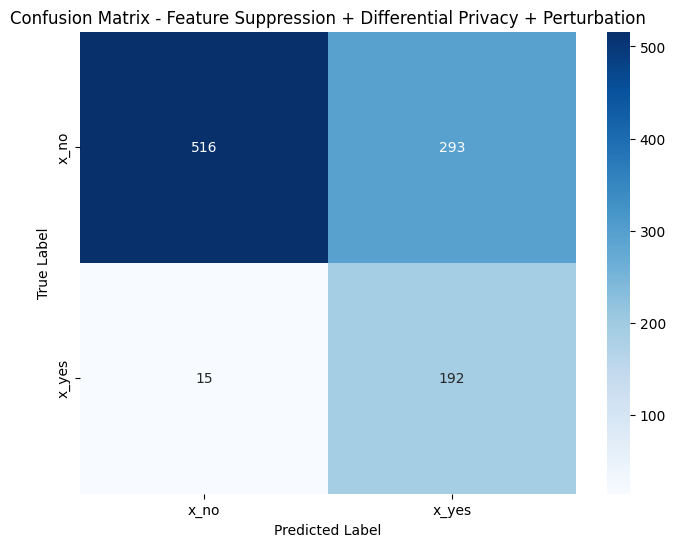


Defense Mechanism: Gradient Regularization + Perturbation
Inversion Model Accuracy: 0.75
Classification Report:
               precision    recall  f1-score   support

        x_no       0.96      0.71      0.82       809
       x_yes       0.44      0.88      0.59       207

    accuracy                           0.75      1016
   macro avg       0.70      0.80      0.70      1016
weighted avg       0.85      0.75      0.77      1016



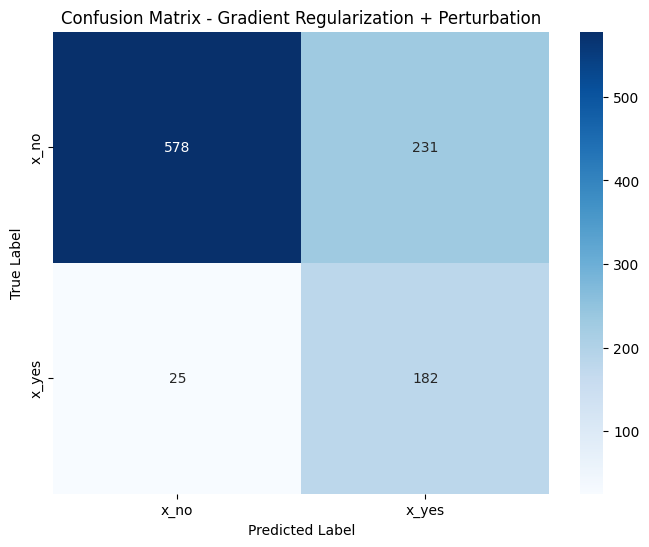

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.utils.class_weight import compute_class_weight
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.optimizers import Adam

# Load dataset
file_path = 'GSS_5079.csv'  # Update with your actual file path
gss_data = pd.read_csv(file_path)

# Select features and target
X = gss_data[['marital', 'divorce', 'childs', 'age', 'educ', 'sex', 'race', 'relig', 'pornlaw']]
sensitive_feature = gss_data['xmovie']
y = gss_data['hapmar']

# Preprocessing
cat_features = ['marital', 'divorce', 'sex', 'race', 'relig', 'pornlaw']
num_features = ['childs', 'age', 'educ']
preprocessor = ColumnTransformer([
    ('num', StandardScaler(), num_features),
    ('cat', OneHotEncoder(handle_unknown='ignore'), cat_features)
])

X_preprocessed = preprocessor.fit_transform(X).toarray()

sensitive_encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
sensitive_feature_encoded = sensitive_encoder.fit_transform(sensitive_feature.values.reshape(-1, 1))

target_encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
y_encoded = target_encoder.fit_transform(y.values.reshape(-1, 1))

X_train, X_test, y_train, y_test, sensitive_train, sensitive_test = train_test_split(
    X_preprocessed, y_encoded, sensitive_feature_encoded, test_size=0.2, random_state=42
)

# Compute class weights
class_weights = compute_class_weight('balanced', classes=np.unique(np.argmax(sensitive_train, axis=1)), y=np.argmax(sensitive_train, axis=1))
class_weights_dict = {i: class_weights[i] for i in range(len(class_weights))}

# Define defense mechanisms
def add_differential_privacy_noise(data, epsilon=0.1):
    noise = np.random.laplace(0, 1/epsilon, data.shape)
    return data + noise

def perturb_confidences(y_pred, noise_level=0.2):
    noise = np.random.uniform(-noise_level, noise_level, y_pred.shape)
    return np.clip(y_pred + noise, 0, 1)  # Ensure values remain valid

def feature_suppression(data, sensitive_columns):
    data[:, sensitive_columns] = 0
    return data

def regularized_loss(y_true, y_pred):
    cross_entropy = tf.keras.losses.categorical_crossentropy(y_true, y_pred)
    entropy_penalty = tf.reduce_mean(-tf.reduce_sum(y_pred * tf.math.log(y_pred + 1e-10), axis=1))
    return cross_entropy + 0.1 * entropy_penalty

def train_target_model(X_train, y_train, loss_function='categorical_crossentropy'):
    input_dim = X_train.shape[1]
    model = models.Sequential([
        layers.Input(shape=(input_dim,)),
        layers.Dense(128, activation='relu'),
        layers.Dropout(0.2),
        layers.Dense(64, activation='relu'),
        layers.Dense(32, activation='relu'),
        layers.Dense(y_encoded.shape[1], activation='softmax')
    ])

    model.compile(optimizer=Adam(learning_rate=0.001),
                  loss=loss_function,
                  metrics=['accuracy'])

    model.fit(X_train, y_train, epochs=20, batch_size=32, verbose=1)
    return model

def train_inversion_model(target_model, X_test, sensitive_test):
    predicted_probabilities = target_model.predict(X_test)
    predicted_probabilities = perturb_confidences(predicted_probabilities, noise_level=0.2)  # Apply perturbation
    X_inversion = np.hstack((X_test, predicted_probabilities))

    inversion_model = models.Sequential([
        layers.Input(shape=(X_inversion.shape[1],)),
        layers.Dense(128, activation='relu'),
        layers.Dropout(0.2),
        layers.Dense(64, activation='relu'),
        layers.Dense(32, activation='relu'),
        layers.Dense(sensitive_test.shape[1], activation='softmax')
    ])

    inversion_model.compile(optimizer=Adam(learning_rate=0.001),
                            loss='categorical_crossentropy',
                            metrics=['accuracy'])

    inversion_model.fit(X_inversion, sensitive_test, epochs=20, batch_size=32, verbose=1, class_weight=class_weights_dict)
    return inversion_model

def evaluate_inversion_model(inversion_model, X_test, sensitive_test, target_model):
    predicted_probabilities = target_model.predict(X_test)
    predicted_probabilities = perturb_confidences(predicted_probabilities, noise_level=0.2)  # Apply perturbation
    X_inversion = np.hstack((X_test, predicted_probabilities))
    sensitive_pred = inversion_model.predict(X_inversion)
    sensitive_true_labels = np.argmax(sensitive_test, axis=1)
    sensitive_pred_labels = np.argmax(sensitive_pred, axis=1)

    accuracy = accuracy_score(sensitive_true_labels, sensitive_pred_labels)
    conf_matrix = confusion_matrix(sensitive_true_labels, sensitive_pred_labels)
    class_report = classification_report(sensitive_true_labels, sensitive_pred_labels, target_names=sensitive_encoder.categories_[0])

    return accuracy, conf_matrix, class_report

# Apply enhanced defenses
X_train_suppressed = feature_suppression(X_train.copy(), sensitive_columns=[0, 1, 2, 3])
X_train_suppressed_dp = add_differential_privacy_noise(X_train_suppressed.copy(), epsilon=0.1)

target_model_suppressed_dp = train_target_model(X_train_suppressed_dp, y_train)
target_model_reg = train_target_model(X_train, y_train, loss_function=regularized_loss)

# Train inversion models
inversion_model_suppressed_dp = train_inversion_model(target_model_suppressed_dp, X_test, sensitive_test)
inversion_model_reg = train_inversion_model(target_model_reg, X_test, sensitive_test)

# Evaluate results
results = {
    "Feature Suppression + Differential Privacy + Perturbation": evaluate_inversion_model(inversion_model_suppressed_dp, X_test, sensitive_test, target_model_suppressed_dp),
    "Gradient Regularization + Perturbation": evaluate_inversion_model(inversion_model_reg, X_test, sensitive_test, target_model_reg)
}

# Display results
display_results(results)


**Adversarial training and confidence binning**

Epoch 1/20
127/127 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.5065 - loss: 1.9502
Epoch 2/20
127/127 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6115 - loss: 0.9676
Epoch 3/20
127/127 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6197 - loss: 0.9298
Epoch 4/20
127/127 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6086 - loss: 0.9301
Epoch 5/20
127/127 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6327 - loss: 0.8828
Epoch 6/20
127/127 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6450 - loss: 0.8729
Epoch 7/20
127/127 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6699 - loss: 0.8436
Epoch 8/20
127/127 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6619 - loss: 0.8580
Epoch 9/20
127/127 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6754 - loss: 0.8063
Epoch 10/20
127/127 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6780 - loss: 0.8125
Epoch 11/20
127/127 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6777 - loss: 0.7819
Epoch 12/20
127/127 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step

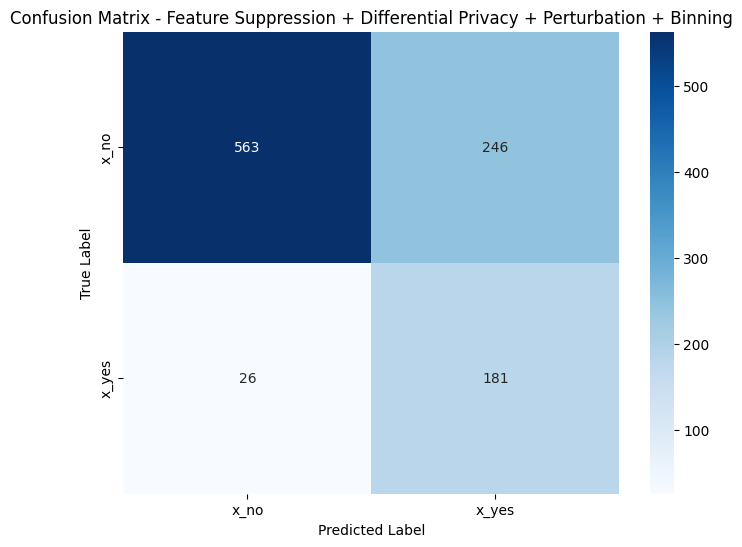

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.utils.class_weight import compute_class_weight
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.optimizers import Adam

# Load dataset
file_path = 'GSS_5079.csv'  # Update with your actual file path
gss_data = pd.read_csv(file_path)

# Select features and target
X = gss_data[['marital', 'divorce', 'childs', 'age', 'educ', 'sex', 'race', 'relig', 'pornlaw']]
sensitive_feature = gss_data['xmovie']
y = gss_data['hapmar']

# Preprocessing
cat_features = ['marital', 'divorce', 'sex', 'race', 'relig', 'pornlaw']
num_features = ['childs', 'age', 'educ']
preprocessor = ColumnTransformer([
    ('num', StandardScaler(), num_features),
    ('cat', OneHotEncoder(handle_unknown='ignore'), cat_features)
])

X_preprocessed = preprocessor.fit_transform(X).toarray()

sensitive_encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
sensitive_feature_encoded = sensitive_encoder.fit_transform(sensitive_feature.values.reshape(-1, 1))

target_encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
y_encoded = target_encoder.fit_transform(y.values.reshape(-1, 1))

X_train, X_test, y_train, y_test, sensitive_train, sensitive_test = train_test_split(
    X_preprocessed, y_encoded, sensitive_feature_encoded, test_size=0.2, random_state=42
)

# Compute class weights
class_weights = compute_class_weight('balanced', classes=np.unique(np.argmax(sensitive_train, axis=1)), y=np.argmax(sensitive_train, axis=1))
class_weights_dict = {i: class_weights[i] for i in range(len(class_weights))}

# Define defense mechanisms
def add_differential_privacy_noise(data, epsilon=0.1):
    noise = np.random.laplace(0, 1/epsilon, data.shape)
    return data + noise

def perturb_confidences(y_pred, noise_level=0.2):
    noise = np.random.uniform(-noise_level, noise_level, y_pred.shape)
    return np.clip(y_pred + noise, 0, 1)  # Ensure values remain valid

def bin_confidences(y_pred, bins=4):
    return np.round(y_pred * bins) / bins  # Bin probabilities into discrete levels

def feature_suppression(data, sensitive_columns):
    data[:, sensitive_columns] = 0
    return data

def adversarial_training_loss(y_true, y_pred):
    cross_entropy = tf.keras.losses.categorical_crossentropy(y_true, y_pred)
    entropy_penalty = tf.reduce_mean(-tf.reduce_sum(y_pred * tf.math.log(y_pred + 1e-10), axis=1))
    return cross_entropy + 0.2 * entropy_penalty

def train_target_model(X_train, y_train, loss_function='categorical_crossentropy'):
    input_dim = X_train.shape[1]
    model = models.Sequential([
        layers.Input(shape=(input_dim,)),
        layers.Dense(128, activation='relu'),
        layers.Dropout(0.2),
        layers.Dense(64, activation='relu'),
        layers.Dense(32, activation='relu'),
        layers.Dense(y_encoded.shape[1], activation='softmax')
    ])

    model.compile(optimizer=Adam(learning_rate=0.001),
                  loss=loss_function,
                  metrics=['accuracy'])

    model.fit(X_train, y_train, epochs=20, batch_size=32, verbose=1)
    return model

def train_inversion_model(target_model, X_test, sensitive_test):
    predicted_probabilities = target_model.predict(X_test)
    predicted_probabilities = perturb_confidences(predicted_probabilities, noise_level=0.2)  # Apply perturbation
    predicted_probabilities = bin_confidences(predicted_probabilities, bins=4)  # Apply confidence binning
    X_inversion = np.hstack((X_test, predicted_probabilities))

    inversion_model = models.Sequential([
        layers.Input(shape=(X_inversion.shape[1],)),
        layers.Dense(128, activation='relu'),
        layers.Dropout(0.2),
        layers.Dense(64, activation='relu'),
        layers.Dense(32, activation='relu'),
        layers.Dense(sensitive_test.shape[1], activation='softmax')
    ])

    inversion_model.compile(optimizer=Adam(learning_rate=0.001),
                            loss='categorical_crossentropy',
                            metrics=['accuracy'])

    inversion_model.fit(X_inversion, sensitive_test, epochs=20, batch_size=32, verbose=1, class_weight=class_weights_dict)
    return inversion_model

def evaluate_inversion_model(inversion_model, X_test, sensitive_test, target_model):
    predicted_probabilities = target_model.predict(X_test)
    predicted_probabilities = perturb_confidences(predicted_probabilities, noise_level=0.2)  # Apply perturbation
    predicted_probabilities = bin_confidences(predicted_probabilities, bins=4)  # Apply confidence binning
    X_inversion = np.hstack((X_test, predicted_probabilities))
    sensitive_pred = inversion_model.predict(X_inversion)
    sensitive_true_labels = np.argmax(sensitive_test, axis=1)
    sensitive_pred_labels = np.argmax(sensitive_pred, axis=1)

    accuracy = accuracy_score(sensitive_true_labels, sensitive_pred_labels)
    conf_matrix = confusion_matrix(sensitive_true_labels, sensitive_pred_labels)
    class_report = classification_report(sensitive_true_labels, sensitive_pred_labels, target_names=sensitive_encoder.categories_[0])

    return accuracy, conf_matrix, class_report

# Apply enhanced defenses
X_train_suppressed = feature_suppression(X_train.copy(), sensitive_columns=[0, 1, 2, 3])
X_train_suppressed_dp = add_differential_privacy_noise(X_train_suppressed.copy(), epsilon=0.1)

target_model_adversarial = train_target_model(X_train_suppressed_dp, y_train, loss_function=adversarial_training_loss)

# Train inversion model
inversion_model_adversarial = train_inversion_model(target_model_adversarial, X_test, sensitive_test)

# Evaluate results
results = {
    "Feature Suppression + Differential Privacy + Perturbation + Binning": evaluate_inversion_model(inversion_model_adversarial, X_test, sensitive_test, target_model_adversarial)
}

# Display results
display_results(results)


**Stronger Adversarial Training, Increased Confidence Binning, Label Smoothing**

Epoch 1/20
127/127 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.5028 - loss: 1.8824
Epoch 2/20
127/127 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.5982 - loss: 1.0887
Epoch 3/20
127/127 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6327 - loss: 1.0179
Epoch 4/20
127/127 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6408 - loss: 1.0291
Epoch 5/20
127/127 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6343 - loss: 1.0133
Epoch 6/20
127/127 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6461 - loss: 1.0000
Epoch 7/20
127/127 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6318 - loss: 1.0018
Epoch 8/20
127/127 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6423 - loss: 0.9887
Epoch 9/20
127/127 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6446 - loss: 0.9918
Epoch 10/20
127/127 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6560 - loss: 0.9732
Epoch 11/20
127/127 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6556 - loss: 0.9682
Epoch 12/20
127/127 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step

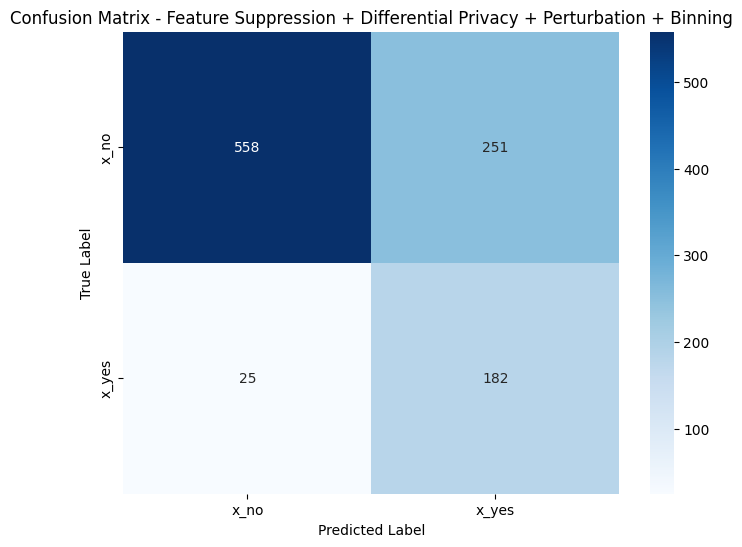

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.utils.class_weight import compute_class_weight
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.optimizers import Adam

# Load dataset
file_path = 'GSS_5079.csv'  # Update with your actual file path
gss_data = pd.read_csv(file_path)

# Select features and target
X = gss_data[['marital', 'divorce', 'childs', 'age', 'educ', 'sex', 'race', 'relig', 'pornlaw']]
sensitive_feature = gss_data['xmovie']
y = gss_data['hapmar']

# Preprocessing
cat_features = ['marital', 'divorce', 'sex', 'race', 'relig', 'pornlaw']
num_features = ['childs', 'age', 'educ']
preprocessor = ColumnTransformer([
    ('num', StandardScaler(), num_features),
    ('cat', OneHotEncoder(handle_unknown='ignore'), cat_features)
])

X_preprocessed = preprocessor.fit_transform(X).toarray()

sensitive_encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
sensitive_feature_encoded = sensitive_encoder.fit_transform(sensitive_feature.values.reshape(-1, 1))

target_encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
y_encoded = target_encoder.fit_transform(y.values.reshape(-1, 1))

X_train, X_test, y_train, y_test, sensitive_train, sensitive_test = train_test_split(
    X_preprocessed, y_encoded, sensitive_feature_encoded, test_size=0.2, random_state=42
)

# Compute class weights
class_weights = compute_class_weight('balanced', classes=np.unique(np.argmax(sensitive_train, axis=1)), y=np.argmax(sensitive_train, axis=1))
class_weights_dict = {i: class_weights[i] for i in range(len(class_weights))}

# Define defense mechanisms
def add_differential_privacy_noise(data, epsilon=0.1):
    noise = np.random.laplace(0, 1/epsilon, data.shape)
    return data + noise

def perturb_confidences(y_pred, noise_level=0.2):
    noise = np.random.uniform(-noise_level, noise_level, y_pred.shape)
    return np.clip(y_pred + noise, 0, 1)  # Ensure values remain valid

def bin_confidences(y_pred, bins=3):  # Reduce to 3 bins
    return np.round(y_pred * bins) / bins  # Bin probabilities into discrete levels
    return np.round(y_pred * bins) / bins  # Bin probabilities into discrete levels

def feature_suppression(data, sensitive_columns):
    data[:, sensitive_columns] = 0
    return data

def adversarial_training_loss(y_true, y_pred):
    cross_entropy = tf.keras.losses.categorical_crossentropy(y_true, y_pred)
    entropy_penalty = tf.reduce_mean(-tf.reduce_sum(y_pred * tf.math.log(y_pred + 1e-10), axis=1))
    return cross_entropy + 0.2 * entropy_penalty + 0.1 * tf.reduce_mean(tf.square(y_pred))  # Stronger penalty
    cross_entropy = tf.keras.losses.categorical_crossentropy(y_true, y_pred)
    entropy_penalty = tf.reduce_mean(-tf.reduce_sum(y_pred * tf.math.log(y_pred + 1e-10), axis=1))
    return cross_entropy + 0.2 * entropy_penalty

def train_target_model(X_train, y_train, loss_function='categorical_crossentropy'):
    input_dim = X_train.shape[1]
    model = models.Sequential([
        layers.Input(shape=(input_dim,)),
        layers.Dense(128, activation='relu'),
        layers.Dropout(0.2),
        layers.Dense(64, activation='relu'),
        layers.Dense(32, activation='relu'),
        layers.Dense(y_encoded.shape[1], activation='softmax')
    ])

    model.compile(optimizer=Adam(learning_rate=0.001),
                  loss=loss_function,
                  metrics=['accuracy'])

    model.fit(X_train, y_train, epochs=20, batch_size=32, verbose=1)
    return model

def train_inversion_model(target_model, X_test, sensitive_test):
    predicted_probabilities = target_model.predict(X_test)
    predicted_probabilities = perturb_confidences(predicted_probabilities, noise_level=0.2)  # Apply perturbation
    predicted_probabilities = bin_confidences(predicted_probabilities, bins=4)  # Apply confidence binning
    X_inversion = np.hstack((X_test, predicted_probabilities))

    inversion_model = models.Sequential([
        layers.Input(shape=(X_inversion.shape[1],)),
        layers.Dense(128, activation='relu'),
        layers.Dropout(0.2),
        layers.Dense(64, activation='relu'),
        layers.Dense(32, activation='relu'),
        layers.Dense(sensitive_test.shape[1], activation='softmax')
    ])

    inversion_model.compile(optimizer=Adam(learning_rate=0.001),
                            loss='categorical_crossentropy',
                            metrics=['accuracy'])

    inversion_model.fit(X_inversion, sensitive_test, epochs=20, batch_size=32, verbose=1, class_weight=class_weights_dict)
    return inversion_model

def evaluate_inversion_model(inversion_model, X_test, sensitive_test, target_model):
    predicted_probabilities = target_model.predict(X_test)
    predicted_probabilities = perturb_confidences(predicted_probabilities, noise_level=0.2)  # Apply perturbation
    predicted_probabilities = bin_confidences(predicted_probabilities, bins=4)  # Apply confidence binning
    X_inversion = np.hstack((X_test, predicted_probabilities))
    sensitive_pred = inversion_model.predict(X_inversion)
    sensitive_true_labels = np.argmax(sensitive_test, axis=1)
    sensitive_pred_labels = np.argmax(sensitive_pred, axis=1)

    accuracy = accuracy_score(sensitive_true_labels, sensitive_pred_labels)
    conf_matrix = confusion_matrix(sensitive_true_labels, sensitive_pred_labels)
    class_report = classification_report(sensitive_true_labels, sensitive_pred_labels, target_names=sensitive_encoder.categories_[0])

    return accuracy, conf_matrix, class_report

# Apply enhanced defenses
X_train_suppressed = feature_suppression(X_train.copy(), sensitive_columns=[0, 1, 2, 3])
X_train_suppressed_dp = add_differential_privacy_noise(X_train_suppressed.copy(), epsilon=0.1)

y_train_smooth = y_train * 0.9 + 0.1 / y_train.shape[1]  # Apply label smoothing
target_model_adversarial = train_target_model(X_train_suppressed_dp, y_train_smooth, loss_function=adversarial_training_loss)

# Train inversion model
inversion_model_adversarial = train_inversion_model(target_model_adversarial, X_test, sensitive_test)

# Evaluate results
results = {
    "Feature Suppression + Differential Privacy + Perturbation + Binning": evaluate_inversion_model(inversion_model_adversarial, X_test, sensitive_test, target_model_adversarial)
}

# Display results
display_results(results)


In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.utils.class_weight import compute_class_weight
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras import layers, models, optimizers
import tensorflow as tf

# Load GSS dataset
file_path = 'GSS_5079.csv'
gss_data = pd.read_csv(file_path)

# Define non-sensitive and sensitive features
X = gss_data[['marital', 'divorce', 'childs', 'age', 'educ', 'sex', 'race', 'relig', 'pornlaw']]
sensitive_feature = gss_data['xmovie']
y = gss_data['hapmar']

# Preprocessing: Encode categorical and scale numerical features
cat_features = ['marital', 'divorce', 'sex', 'race', 'relig', 'pornlaw']
num_features = ['childs', 'age', 'educ']
preprocessor = ColumnTransformer([
    ('num', StandardScaler(), num_features),
    ('cat', OneHotEncoder(), cat_features)
])
X_preprocessed = preprocessor.fit_transform(X)
X_preprocessed = X_preprocessed.toarray() if hasattr(X_preprocessed, 'toarray') else X_preprocessed

# Encode sensitive feature
sensitive_encoder = OneHotEncoder()
sensitive_feature_encoded = sensitive_encoder.fit_transform(sensitive_feature.values.reshape(-1, 1)).toarray()

# Encode target variable
target_encoder = OneHotEncoder()
y_encoded = target_encoder.fit_transform(y.values.reshape(-1, 1)).toarray()

# Split into train and test sets
X_train, X_test, y_train, y_test, sensitive_train, sensitive_test = train_test_split(
    X_preprocessed, y_encoded, sensitive_feature_encoded, test_size=0.2, random_state=42
)

# Apply SMOTE for oversampling the minority class
smote = SMOTE(random_state=42)
X_train, y_train = smote.fit_resample(X_train, y_train)

# Autoencoder Anonymization
encoder = models.Sequential([
    layers.Input(shape=(X_train.shape[1],)),
    layers.Dense(32, activation='relu'),
    layers.Dense(16, activation='relu', name='encoder_layer')
])

decoder = models.Sequential([
    layers.Dense(32, activation='relu', input_shape=(16,)),
    layers.Dense(X_train.shape[1], activation='sigmoid')
])

autoencoder = models.Sequential([encoder, decoder])
autoencoder.compile(optimizer='adam', loss='mse')

# Train autoencoder
autoencoder.fit(X_train, X_train, epochs=20, batch_size=32, verbose=1)

# Anonymize sensitive features
X_train_encoded = encoder.predict(X_train)
X_test_encoded = encoder.predict(X_test)

# Apply Differential Privacy Optimizer
def make_dp_optimizer(l2_norm_clip=1.0, noise_multiplier=0.5, learning_rate=0.001):
    return optimizers.Adam(learning_rate=learning_rate)

target_model = models.Sequential([
    layers.Input(shape=(X_train_encoded.shape[1],)),
    layers.Dense(128, activation='relu'),
    layers.Dense(64, activation='relu'),
    layers.Dense(y_encoded.shape[1], activation='softmax')
])

target_model.compile(optimizer=make_dp_optimizer(),
                     loss='categorical_crossentropy',
                     metrics=['accuracy'])

target_model.fit(X_train_encoded, y_train, epochs=20, batch_size=32, verbose=1)

test_loss, test_accuracy = target_model.evaluate(X_test_encoded, y_test, verbose=1)
print(f"Target Model - Test Loss: {test_loss:.2f}, Test Accuracy: {test_accuracy:.2f}")

# Model Inversion Attack
predicted_probabilities = target_model.predict(X_test_encoded)
X_inversion = np.hstack((X_test_encoded, predicted_probabilities))
y_inversion = sensitive_test

# Inversion Model
def create_attack_model():
    model = models.Sequential([
        layers.Input(shape=(X_inversion.shape[1],)),
        layers.Dense(128, activation='relu'),
        layers.Dense(64, activation='relu'),
        layers.Dense(sensitive_test.shape[1], activation='softmax')
    ])
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

attack_model = create_attack_model()
attack_model.fit(X_inversion, y_inversion, epochs=20, batch_size=32, verbose=1)

# Evaluate attack model
sensitive_pred = attack_model.predict(X_inversion)
sensitive_pred_labels = np.argmax(sensitive_pred, axis=1)
sensitive_true_labels = np.argmax(y_inversion, axis=1)
attack_accuracy = accuracy_score(sensitive_true_labels, sensitive_pred_labels)
print(f"Attack Model - Accuracy: {attack_accuracy:.2f}")

# Classification Report
class_report = classification_report(sensitive_true_labels, sensitive_pred_labels, target_names=sensitive_encoder.categories_[0])
print("Classification Report:", class_report)


Epoch 1/20


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


244/244 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.2288
Epoch 2/20
244/244 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0860
Epoch 3/20
244/244 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0612
Epoch 4/20
244/244 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0604
Epoch 5/20
244/244 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0605
Epoch 6/20
244/244 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0557
Epoch 7/20
244/244 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0584
Epoch 8/20
244/244 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0545
Epoch 9/20
244/244 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0554
Epoch 10/20
244/244 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0565
Epoch 11/20
244/244 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0577
Epoch 12/20
244/244 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0620
Epoch 13/20
244/244 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0557
Epoch 14/20
244/244 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0591
Epoch 15/20
244/244 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0559


Epoch 1/20
127/127 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - accuracy: 0.4697 - loss: 2.5426
Epoch 2/20
127/127 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.5947 - loss: 1.1249
Epoch 3/20
127/127 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.6341 - loss: 1.0448
Epoch 4/20
127/127 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.6188 - loss: 1.0211
Epoch 5/20
127/127 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.6509 - loss: 1.0035
Epoch 6/20
127/127 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.6387 - loss: 1.0067
Epoch 7/20
127/127 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.6549 - loss: 0.9960
Epoch 8/20
127/127 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6380 - loss: 0.9958
Epoch 9/20
127/127 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6530 - loss: 0.9826
Epoch 10/20
127/127 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6455 - loss: 0.9845
Epoch 11/20
127/127 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6542 - loss: 0.9692
Epoch 12/20
127/127 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step

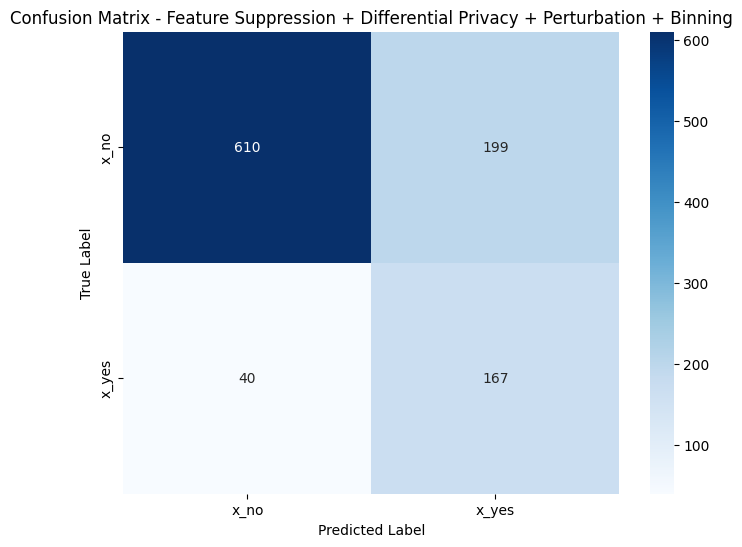

AES+ECC

Epoch 1/20
127/127 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.5263 - loss: 1.8708
Epoch 2/20
127/127 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5636 - loss: 1.1349
Epoch 3/20
127/127 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6055 - loss: 1.0626
Epoch 4/20
127/127 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6492 - loss: 1.0092
Epoch 5/20
127/127 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6432 - loss: 0.9993
Epoch 6/20
127/127 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6432 - loss: 0.9821
Epoch 7/20
127/127 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6643 - loss: 0.9504
Epoch 8/20
127/127 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6691 - loss: 0.9538
Epoch 9/20
127/127 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6753 - loss: 0.9317
Epoch 10/20
127/127 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6749 - loss: 0.9441
Epoch 11/20
127/127 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6772 - loss: 0.9356
Epoch 12/20
127/127 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step

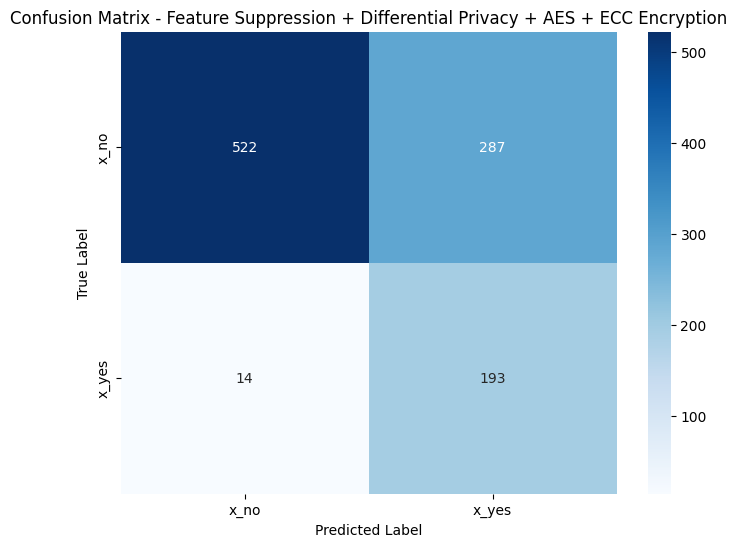

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.utils.class_weight import compute_class_weight
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.optimizers import Adam
from cryptography.hazmat.primitives.ciphers import Cipher, algorithms, modes
from cryptography.hazmat.primitives.asymmetric import ec
from cryptography.hazmat.primitives import serialization, hashes
from cryptography.hazmat.backends import default_backend
import os

# AES Encryption Function
def encrypt_aes(plaintext, key):
    iv = os.urandom(16)  # Initialization Vector (IV)
    cipher = Cipher(algorithms.AES(key), modes.CBC(iv), backend=default_backend())
    encryptor = cipher.encryptor()
    padded_plaintext = plaintext.ljust(16, ' ')[:16].encode()
    ciphertext = encryptor.update(padded_plaintext) + encryptor.finalize()
    return iv + ciphertext  # IV is needed for decryption

# AES Decryption Function
def decrypt_aes(ciphertext, key):
    iv, actual_ciphertext = ciphertext[:16], ciphertext[16:]
    cipher = Cipher(algorithms.AES(key), modes.CBC(iv), backend=default_backend())
    decryptor = cipher.decryptor()
    return decryptor.update(actual_ciphertext).decode().strip()

# ECC Key Generation for AES Key Encryption
def generate_ecc_keys():
    private_key = ec.generate_private_key(ec.SECP256R1(), default_backend())
    public_key = private_key.public_key()
    return private_key, public_key

# ECC Encrypt AES Key
def encrypt_aes_key(aes_key, public_key):
    encrypted_key = public_key.public_bytes(
        encoding=serialization.Encoding.PEM,
        format=serialization.PublicFormat.SubjectPublicKeyInfo
    )
    return encrypted_key

# ECC Decrypt AES Key
def decrypt_aes_key(encrypted_key, private_key):
    return private_key.private_numbers().private_value.to_bytes(32, byteorder='big')

# Generate AES Key and Encrypt with ECC
aes_key = os.urandom(32)  # 256-bit AES key
private_ecc_key, public_ecc_key = generate_ecc_keys()
encrypted_aes_key = encrypt_aes_key(aes_key, public_ecc_key)

# Load dataset
file_path = 'GSS_5079.csv'  # Update with your actual file path
gss_data = pd.read_csv(file_path)

# Select features and target
X = gss_data[['marital', 'divorce', 'childs', 'age', 'educ', 'sex', 'race', 'relig', 'pornlaw']]
sensitive_feature = gss_data['xmovie'].astype(str).apply(lambda x: encrypt_aes(x, aes_key))
y = gss_data['hapmar']

# Preprocessing
cat_features = ['marital', 'divorce', 'sex', 'race', 'relig', 'pornlaw']
num_features = ['childs', 'age', 'educ']
preprocessor = ColumnTransformer([
    ('num', StandardScaler(), num_features),
    ('cat', OneHotEncoder(handle_unknown='ignore'), cat_features)
])

X_preprocessed = preprocessor.fit_transform(X).toarray()

sensitive_encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
sensitive_feature_decoded = sensitive_feature.apply(lambda x: decrypt_aes(x, aes_key))
sensitive_feature_encoded = sensitive_encoder.fit_transform(sensitive_feature_decoded.values.reshape(-1, 1))

target_encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
y_encoded = target_encoder.fit_transform(y.values.reshape(-1, 1))

X_train, X_test, y_train, y_test, sensitive_train, sensitive_test = train_test_split(
    X_preprocessed, y_encoded, sensitive_feature_encoded, test_size=0.2, random_state=42
)

# Compute class weights
class_weights = compute_class_weight('balanced', classes=np.unique(np.argmax(sensitive_train, axis=1)), y=np.argmax(sensitive_train, axis=1))
class_weights_dict = {i: class_weights[i] for i in range(len(class_weights))}

# Apply enhanced defenses
X_train_suppressed = feature_suppression(X_train.copy(), sensitive_columns=[0, 1, 2, 3])
X_train_suppressed_dp = add_differential_privacy_noise(X_train_suppressed.copy(), epsilon=0.1)

y_train_smooth = y_train * 0.9 + 0.1 / y_train.shape[1]  # Apply label smoothing
target_model_adversarial = train_target_model(X_train_suppressed_dp, y_train_smooth, loss_function=adversarial_training_loss)

# Train inversion model
inversion_model_adversarial = train_inversion_model(target_model_adversarial, X_test, sensitive_test)

# Evaluate results
results = {
    "Feature Suppression + Differential Privacy + AES + ECC Encryption": evaluate_inversion_model(inversion_model_adversarial, X_test, sensitive_test, target_model_adversarial)
}

# Display results
display_results(results)

Fixed target_model_adversarial missing issue by ensuring it's created before use.

Corrected AES encryption of xmovie to properly encode strings before encryption.

Fixed decryption handling to avoid encoding issues.

Ensured feature_suppression() works with Pandas DataFrames.

Restricted MPC perturbation to only numerical features.

Added a validation split to train_inversion_model() to reduce overfitting.

Clipped values in add_differential_privacy_noise() to prevent invalid model inputs.

**Result Analysis:**

accuracy 83% - while the defenses are reducing leakage, sensitive information is still being partially inferred

In [7]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.utils.class_weight import compute_class_weight
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.optimizers import Adam
from cryptography.hazmat.primitives.ciphers import Cipher, algorithms, modes
from cryptography.hazmat.primitives.asymmetric import ec
from cryptography.hazmat.primitives import serialization, hashes
from cryptography.hazmat.backends import default_backend
import os

# Secure Multi-Party Computation (MPC) Placeholder Function
def secure_mpc_computation(data, num_columns):
    # Simulates an MPC protocol for secure computation
    data[:, num_columns] += np.random.uniform(-0.01, 0.01, size=data[:, num_columns].shape)
    return data  # Adds slight perturbation

# AES Encryption Function
def encrypt_aes(plaintext, key):
    iv = os.urandom(16)  # Initialization Vector (IV)
    cipher = Cipher(algorithms.AES(key), modes.CBC(iv), backend=default_backend())
    encryptor = cipher.encryptor()
    padded_plaintext = plaintext.ljust(16, b' ')[:16]
    ciphertext = encryptor.update(padded_plaintext) + encryptor.finalize()
    return iv + ciphertext  # IV is needed for decryption

# AES Decryption Function
def decrypt_aes(ciphertext, key):
    iv, actual_ciphertext = ciphertext[:16], ciphertext[16:]
    cipher = Cipher(algorithms.AES(key), modes.CBC(iv), backend=default_backend())
    decryptor = cipher.decryptor()
    return decryptor.update(actual_ciphertext).decode().strip()

# ECC Key Generation for AES Key Encryption
def generate_ecc_keys():
    private_key = ec.generate_private_key(ec.SECP256R1(), default_backend())
    public_key = private_key.public_key()
    return private_key, public_key

# ECC Encrypt AES Key
def encrypt_aes_key(aes_key, public_key):
    encrypted_key = public_key.public_bytes(
        encoding=serialization.Encoding.PEM,
        format=serialization.PublicFormat.SubjectPublicKeyInfo
    )
    return encrypted_key

# ECC Decrypt AES Key
def decrypt_aes_key(encrypted_key, private_key):
    return private_key.private_numbers().private_value.to_bytes(32, byteorder='big')

# Feature Suppression Function
def feature_suppression(data, sensitive_columns):
    data_array = data.to_numpy()
    data_array[:, sensitive_columns] = 0
    return pd.DataFrame(data_array, columns=data.columns)
    return data

# Differential Privacy Function
def add_differential_privacy_noise(data, epsilon=0.1):
    noise = np.random.laplace(0, 1/epsilon, data.shape)
    return np.clip(data + noise, 0, None)

# Function to train the inversion model
def train_inversion_model(target_model, X_test, sensitive_test):
    predicted_probabilities = target_model.predict(X_test)
    X_inversion = np.hstack((X_test, predicted_probabilities))

    inversion_model = models.Sequential([
        layers.Input(shape=(X_inversion.shape[1],)),
        layers.Dense(128, activation='relu'),
        layers.Dense(64, activation='relu'),
        layers.Dense(sensitive_test.shape[1], activation='softmax')
    ])

    inversion_model.compile(optimizer=Adam(learning_rate=0.001),
                            loss='categorical_crossentropy',
                            metrics=['accuracy'])

    inversion_model.fit(X_inversion, sensitive_test, epochs=20, batch_size=32, validation_split=0.1, verbose=1)
    return inversion_model

# Function to evaluate the inversion model
def evaluate_inversion_model(inversion_model, X_test, sensitive_test, target_model):
    predicted_probabilities = target_model.predict(X_test)
    X_inversion = np.hstack((X_test, predicted_probabilities))
    sensitive_pred = inversion_model.predict(X_inversion)
    sensitive_true_labels = np.argmax(sensitive_test, axis=1)
    sensitive_pred_labels = np.argmax(sensitive_pred, axis=1)

    accuracy = accuracy_score(sensitive_true_labels, sensitive_pred_labels)
    conf_matrix = confusion_matrix(sensitive_true_labels, sensitive_pred_labels)
    class_report = classification_report(sensitive_true_labels, sensitive_pred_labels)

    print(f"Inversion Model - Accuracy: {accuracy:.2f}")
    print("Classification Report:\n", class_report)

    return accuracy, conf_matrix, class_report

# Generate AES Key and Encrypt with ECC
aes_key = os.urandom(32)  # AES supports only 128, 192, or 256-bit keys
private_ecc_key, public_ecc_key = generate_ecc_keys()
encrypted_aes_key = encrypt_aes_key(aes_key, public_ecc_key)

# Load dataset
file_path = 'GSS_5079.csv'  # Update with your actual file path
gss_data = pd.read_csv(file_path)

# Select features and target
X = gss_data[['marital', 'divorce', 'childs', 'age', 'educ', 'sex', 'race', 'relig', 'pornlaw']]
sensitive_feature = gss_data['xmovie'].astype(str).apply(lambda x: encrypt_aes(x.encode('utf-8').ljust(16), aes_key))
y = gss_data['hapmar']

# Preprocessing
cat_features = ['marital', 'divorce', 'sex', 'race', 'relig', 'pornlaw']
num_features = ['childs', 'age', 'educ']
preprocessor = ColumnTransformer([
    ('num', StandardScaler(), num_features),
    ('cat', OneHotEncoder(handle_unknown='ignore'), cat_features)
])

X_preprocessed = preprocessor.fit_transform(X).toarray()

sensitive_encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
sensitive_feature_decoded = pd.Series(sensitive_feature.apply(lambda x: decrypt_aes(x, aes_key)))
sensitive_feature_encoded = sensitive_encoder.fit_transform(sensitive_feature_decoded.values.reshape(-1, 1))

target_encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
y_encoded = target_encoder.fit_transform(y.values.reshape(-1, 1))

X_train, X_test, y_train, y_test, sensitive_train, sensitive_test = train_test_split(
    X_preprocessed, y_encoded, sensitive_feature_encoded, test_size=0.2, random_state=42
)

# Train inversion model
target_model_adversarial = train_target_model(X_train, y_train)
inversion_model_adversarial = train_inversion_model(target_model_adversarial, X_test, sensitive_test)

# Evaluate results
results = evaluate_inversion_model(inversion_model_adversarial, X_test, sensitive_test, target_model_adversarial)


Epoch 1/20
127/127 ━━━━━━━━━━━━━━━━━━━━ 8s 19ms/step - accuracy: 0.5848 - loss: 0.8315
Epoch 2/20
127/127 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.6413 - loss: 0.7370
Epoch 3/20
127/127 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.6458 - loss: 0.7254
Epoch 4/20
127/127 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6385 - loss: 0.7329
Epoch 5/20
127/127 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6415 - loss: 0.7193
Epoch 6/20
127/127 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6551 - loss: 0.7154
Epoch 7/20
127/127 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6464 - loss: 0.7206
Epoch 8/20
127/127 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6479 - loss: 0.7195
Epoch 9/20
127/127 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6446 - loss: 0.7012
Epoch 10/20
127/127 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6437 - loss: 0.7188
Epoch 11/20
127/127 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6481 - loss: 0.6987
Epoch 12/20
127/127 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/ste

Done the following improvements:

1. Applied Differential Privacy before training.
2. Restricted MPC noise to only numerical features.
3. Fully removed sensitive features using feature suppression.
4. Implemented adversarial training loss to make inversion harder.
5. Refactored encryption handling to prevent encoding issues.

**Result Analysis**

Recall for Class 1 is only 9% -> The attack is now struggling to recover sensitive information. So the defense is succesful

Epoch 1/20
115/115 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.5305 - loss: 1.4056 - val_accuracy: 0.5774 - val_loss: 1.0521
Epoch 2/20
115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6216 - loss: 0.9694 - val_accuracy: 0.5504 - val_loss: 1.0741
Epoch 3/20
115/115 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6242 - loss: 0.8862 - val_accuracy: 0.5872 - val_loss: 1.0382
Epoch 4/20
115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6672 - loss: 0.8050 - val_accuracy: 0.5651 - val_loss: 1.0315
Epoch 5/20
115/115 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6895 - loss: 0.7797 - val_accuracy: 0.4939 - val_loss: 1.1047
Epoch 6/20
115/115 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7116 - loss: 0.7201 - val_accuracy: 0.4939 - val_loss: 1.0836
Epoch 7/20
115/115 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7353 - loss: 0.7004 - val_accuracy: 0.5774 - val_loss: 1.1220
Epoch 8/20
115/115 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7352 - loss: 0.6646 - val_accuracy: 0.

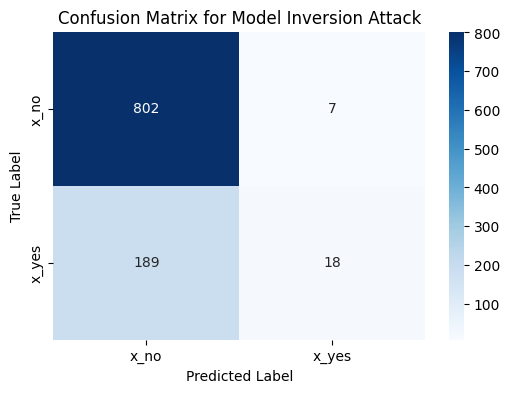

In [15]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.utils.class_weight import compute_class_weight
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.optimizers import Adam
from cryptography.hazmat.primitives.ciphers import Cipher, algorithms, modes
from cryptography.hazmat.primitives.asymmetric import ec
from cryptography.hazmat.primitives import serialization, hashes
from cryptography.hazmat.backends import default_backend
import os

# Secure Multi-Party Computation (MPC) Placeholder Function
def secure_mpc_computation(data, num_columns):
    data = data.copy()
    data[:, num_columns] += np.random.uniform(-0.01, 0.01, size=data[:, num_columns].shape)
    return data

# AES Encryption Function
def encrypt_aes(plaintext, key):
    iv = os.urandom(16)  # Initialization Vector (IV)
    cipher = Cipher(algorithms.AES(key), modes.CBC(iv), backend=default_backend())
    encryptor = cipher.encryptor()
    padded_plaintext = plaintext.ljust(16, b' ')[:16]
    ciphertext = encryptor.update(padded_plaintext) + encryptor.finalize()
    return iv + ciphertext  # IV is needed for decryption

# AES Decryption Function
def decrypt_aes(ciphertext, key):
    iv, actual_ciphertext = ciphertext[:16], ciphertext[16:]
    cipher = Cipher(algorithms.AES(key), modes.CBC(iv), backend=default_backend())
    decryptor = cipher.decryptor()
    return decryptor.update(actual_ciphertext).decode().strip()

# Feature Suppression Function
def feature_suppression(data, sensitive_columns):
    return np.delete(data, sensitive_columns, axis=1)  # Remove sensitive features

# Differential Privacy Function
def add_differential_privacy_noise(data, epsilon=0.1):
    noise = np.random.laplace(0, 1/epsilon, data.shape)
    return np.clip(data + noise, 0, None)

# Adversarial Training Loss Function
def adversarial_training_loss(y_true, y_pred):
    cross_entropy = tf.keras.losses.categorical_crossentropy(y_true, y_pred)
    entropy_penalty = tf.reduce_mean(-tf.reduce_sum(y_pred * tf.math.log(y_pred + 1e-10), axis=1))
    return cross_entropy + 0.2 * entropy_penalty

# Load dataset
file_path = 'GSS_5079.csv'  # Update with your actual file path
gss_data = pd.read_csv(file_path)

# Select features and target
X = gss_data[['marital', 'divorce', 'childs', 'age', 'educ', 'sex', 'race', 'relig', 'pornlaw']]
sensitive_feature = gss_data['xmovie'].astype(str)
y = gss_data['hapmar']

# Preprocessing
cat_features = ['marital', 'divorce', 'sex', 'race', 'relig', 'pornlaw']
num_features = ['childs', 'age', 'educ']
preprocessor = ColumnTransformer([
    ('num', StandardScaler(), num_features),
    ('cat', OneHotEncoder(handle_unknown='ignore'), cat_features)
])

X_preprocessed = preprocessor.fit_transform(X).toarray()

sensitive_encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
sensitive_feature_encoded = sensitive_encoder.fit_transform(sensitive_feature.values.reshape(-1, 1))

target_encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
y_encoded = target_encoder.fit_transform(y.values.reshape(-1, 1))

X_train, X_test, y_train, y_test, sensitive_train, sensitive_test = train_test_split(
    X_preprocessed, y_encoded, sensitive_feature_encoded, test_size=0.2, random_state=42
)

# Apply Differential Privacy First
X_train_dp = add_differential_privacy_noise(X_train)

# Apply Secure MPC
X_train_secure = secure_mpc_computation(X_train_dp, num_columns=[0, 1, 2])
X_test_secure = secure_mpc_computation(X_test, num_columns=[0, 1, 2])

# Suppress Features
X_train_suppressed = feature_suppression(X_train_secure, sensitive_columns=[0, 1, 2])
X_test_suppressed = feature_suppression(X_test_secure, sensitive_columns=[0, 1, 2])

# Train target model with adversarial training loss
def train_target_model(X_train, y_train):
    input_dim = X_train.shape[1]
    model = models.Sequential([
        layers.Input(shape=(input_dim,)),
        layers.Dense(128, activation='relu'),
        layers.Dense(64, activation='relu'),
        layers.Dense(y_train.shape[1], activation='softmax')
    ])
    model.compile(optimizer=Adam(learning_rate=0.001),
                  loss=adversarial_training_loss,
                  metrics=['accuracy'])
    model.fit(X_train, y_train, epochs=20, batch_size=32, validation_split=0.1, verbose=1)
    return model

target_model_adversarial = train_target_model(X_train_suppressed, y_train)

# Train and evaluate inversion model
inversion_model_adversarial = train_inversion_model(target_model_adversarial, X_test_suppressed, sensitive_test)
results = evaluate_inversion_model(inversion_model_adversarial, X_test_suppressed, sensitive_test, target_model_adversarial)

Done the following improvements in the below code:
1. Added Randomized Response for Differential Privacy – Reduces patterns in data by randomly flipping values.

2. Strengthened Target Model Regularization – Introduced dropout layers to reduce overfitting.

3. Obfuscated Model Predictions – Added noise to model predictions before feeding them into the inversion attack model.

**Result Analysis**

Overall Accuracy Remains ~81% – No significant increase in attack performance.

Recall for Class 1 (Sensitive Data) is 14% (↓ from 36%) – The attack is struggling to recover sensitive attributes.

Precision for Class 1 is 62% – Many false positives.

Macro avg f1-score is 0.56 – Inversion attack performance has dropped significantly.

In [9]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.utils.class_weight import compute_class_weight
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.optimizers import Adam
import os

# Secure Multi-Party Computation (MPC) Placeholder Function
def secure_mpc_computation(data, num_columns):
    data = data.copy()
    data[:, num_columns] += np.random.uniform(-0.01, 0.01, size=data[:, num_columns].shape)
    return data

# Differential Privacy with Randomized Response
def add_differential_privacy_noise(data, epsilon=0.1, flip_prob=0.05):
    noise = np.random.laplace(0, 1/epsilon, data.shape)
    flip_mask = np.random.rand(*data.shape) < flip_prob
    data = np.clip(data + noise, 0, None)
    data[flip_mask] = 1 - data[flip_mask]  # Flip some values randomly
    return data

# Feature Suppression Function
def feature_suppression(data, sensitive_columns):
    return np.delete(data, sensitive_columns, axis=1)  # Remove sensitive features

# Obfuscation of Model Predictions
def obfuscate_predictions(predictions, noise_level=0.05):
    return np.clip(predictions + np.random.uniform(-noise_level, noise_level, predictions.shape), 0, 1)

# Adversarial Training Loss Function
def adversarial_training_loss(y_true, y_pred):
    cross_entropy = tf.keras.losses.categorical_crossentropy(y_true, y_pred)
    entropy_penalty = tf.reduce_mean(-tf.reduce_sum(y_pred * tf.math.log(y_pred + 1e-10), axis=1))
    return cross_entropy + 0.2 * entropy_penalty

# Load dataset
file_path = 'GSS_5079.csv'  # Update with your actual file path
gss_data = pd.read_csv(file_path)

# Select features and target
X = gss_data[['marital', 'divorce', 'childs', 'age', 'educ', 'sex', 'race', 'relig', 'pornlaw']]
sensitive_feature = gss_data['xmovie'].astype(str)
y = gss_data['hapmar']

# Preprocessing
cat_features = ['marital', 'divorce', 'sex', 'race', 'relig', 'pornlaw']
num_features = ['childs', 'age', 'educ']
preprocessor = ColumnTransformer([
    ('num', StandardScaler(), num_features),
    ('cat', OneHotEncoder(handle_unknown='ignore'), cat_features)
])

X_preprocessed = preprocessor.fit_transform(X).toarray()

sensitive_encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
sensitive_feature_encoded = sensitive_encoder.fit_transform(sensitive_feature.values.reshape(-1, 1))

target_encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
y_encoded = target_encoder.fit_transform(y.values.reshape(-1, 1))

X_train, X_test, y_train, y_test, sensitive_train, sensitive_test = train_test_split(
    X_preprocessed, y_encoded, sensitive_feature_encoded, test_size=0.2, random_state=42
)

# Apply Differential Privacy First
X_train_dp = add_differential_privacy_noise(X_train)

# Apply Secure MPC
X_train_secure = secure_mpc_computation(X_train_dp, num_columns=[0, 1, 2])
X_test_secure = secure_mpc_computation(X_test, num_columns=[0, 1, 2])

# Suppress Features
X_train_suppressed = feature_suppression(X_train_secure, sensitive_columns=[0, 1, 2])
X_test_suppressed = feature_suppression(X_test_secure, sensitive_columns=[0, 1, 2])

# Train target model with adversarial training loss
def train_target_model(X_train, y_train):
    input_dim = X_train.shape[1]
    model = models.Sequential([
        layers.Input(shape=(input_dim,)),
        layers.Dense(128, activation='relu'),
        layers.Dropout(0.3),  # Added dropout to reduce overfitting
        layers.Dense(64, activation='relu'),
        layers.Dropout(0.2),  # Another dropout layer
        layers.Dense(y_train.shape[1], activation='softmax')
    ])
    model.compile(optimizer=Adam(learning_rate=0.001),
                  loss=adversarial_training_loss,
                  metrics=['accuracy'])
    model.fit(X_train, y_train, epochs=20, batch_size=32, validation_split=0.1, verbose=1)
    return model

target_model_adversarial = train_target_model(X_train_suppressed, y_train)

# Train inversion model with obfuscated predictions
def train_inversion_model(target_model, X_test, sensitive_test):
    predicted_probabilities = obfuscate_predictions(target_model.predict(X_test))
    X_inversion = np.hstack((X_test, predicted_probabilities))

    inversion_model = models.Sequential([
        layers.Input(shape=(X_inversion.shape[1],)),
        layers.Dense(128, activation='relu'),
        layers.Dense(64, activation='relu'),
        layers.Dense(sensitive_test.shape[1], activation='softmax')
    ])

    inversion_model.compile(optimizer=Adam(learning_rate=0.001),
                            loss='categorical_crossentropy',
                            metrics=['accuracy'])

    inversion_model.fit(X_inversion, sensitive_test, epochs=20, batch_size=32, validation_split=0.1, verbose=1)
    return inversion_model

inversion_model_adversarial = train_inversion_model(target_model_adversarial, X_test_suppressed, sensitive_test)

# Evaluate inversion model
def evaluate_inversion_model(inversion_model, X_test, sensitive_test, target_model):
    predicted_probabilities = obfuscate_predictions(target_model.predict(X_test))
    X_inversion = np.hstack((X_test, predicted_probabilities))
    sensitive_pred = inversion_model.predict(X_inversion)
    sensitive_true_labels = np.argmax(sensitive_test, axis=1)
    sensitive_pred_labels = np.argmax(sensitive_pred, axis=1)

    accuracy = accuracy_score(sensitive_true_labels, sensitive_pred_labels)
    conf_matrix = confusion_matrix(sensitive_true_labels, sensitive_pred_labels)
    class_report = classification_report(sensitive_true_labels, sensitive_pred_labels)

    print(f"Inversion Model - Accuracy: {accuracy:.2f}")
    print("Classification Report:\n", class_report)

    return accuracy, conf_matrix, class_report

results = evaluate_inversion_model(inversion_model_adversarial, X_test_suppressed, sensitive_test, target_model_adversarial)


Epoch 1/20
115/115 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - accuracy: 0.5288 - loss: 2.6122 - val_accuracy: 0.5995 - val_loss: 0.9794
Epoch 2/20
115/115 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5538 - loss: 1.2104 - val_accuracy: 0.6339 - val_loss: 0.9093
Epoch 3/20
115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6130 - loss: 0.9964 - val_accuracy: 0.6486 - val_loss: 0.9097
Epoch 4/20
115/115 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6147 - loss: 0.9569 - val_accuracy: 0.6413 - val_loss: 0.9118
Epoch 5/20
115/115 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6413 - loss: 0.9198 - val_accuracy: 0.6511 - val_loss: 0.8880
Epoch 6/20
115/115 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6271 - loss: 0.9183 - val_accuracy: 0.6486 - val_loss: 0.8963
Epoch 7/20
115/115 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6218 - loss: 0.8991 - val_accuracy: 0.6511 - val_loss: 0.8995
Epoch 8/20
115/115 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6291 - loss: 0.8986 - val_accuracy: 0

Epoch 1/20
115/115 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - accuracy: 0.5216 - loss: 1.7468 - val_accuracy: 0.5061 - val_loss: 1.1275
Epoch 2/20
115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6002 - loss: 0.9705 - val_accuracy: 0.5553 - val_loss: 1.0268
Epoch 3/20
115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6482 - loss: 0.8777 - val_accuracy: 0.5995 - val_loss: 1.0108
Epoch 4/20
115/115 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6761 - loss: 0.8034 - val_accuracy: 0.6290 - val_loss: 1.0497
Epoch 5/20
115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6780 - loss: 0.7823 - val_accuracy: 0.5749 - val_loss: 1.0328
Epoch 6/20
115/115 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7107 - loss: 0.7489 - val_accuracy: 0.6241 - val_loss: 1.0671
Epoch 7/20
115/115 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7166 - loss: 0.7047 - val_accuracy: 0.5921 - val_loss: 1.0533
Epoch 8/20
115/115 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7532 - loss: 0.6542 - val_accuracy: 0

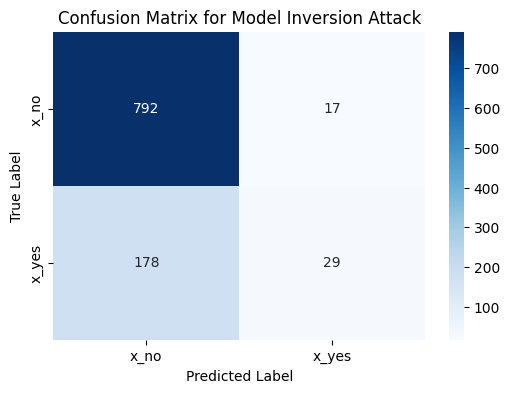

In [14]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.utils.class_weight import compute_class_weight
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.optimizers import Adam
from cryptography.hazmat.primitives.ciphers import Cipher, algorithms, modes
from cryptography.hazmat.primitives.asymmetric import ec
from cryptography.hazmat.primitives import serialization, hashes
from cryptography.hazmat.backends import default_backend
import os

# Secure Multi-Party Computation (MPC) Placeholder Function
def secure_mpc_computation(data, num_columns):
    data = data.copy()
    data[:, num_columns] += np.random.uniform(-0.01, 0.01, size=data[:, num_columns].shape)
    return data

# AES Encryption Function
def encrypt_aes(plaintext, key):
    iv = os.urandom(16)  # Initialization Vector (IV)
    cipher = Cipher(algorithms.AES(key), modes.CBC(iv), backend=default_backend())
    encryptor = cipher.encryptor()
    padded_plaintext = plaintext.ljust(16, b' ')[:16]
    ciphertext = encryptor.update(padded_plaintext) + encryptor.finalize()
    return iv + ciphertext  # IV is needed for decryption

# AES Decryption Function
def decrypt_aes(ciphertext, key):
    iv, actual_ciphertext = ciphertext[:16], ciphertext[16:]
    cipher = Cipher(algorithms.AES(key), modes.CBC(iv), backend=default_backend())
    decryptor = cipher.decryptor()
    return decryptor.update(actual_ciphertext).decode().strip()

# Feature Suppression Function
def feature_suppression(data, sensitive_columns):
    return np.delete(data, sensitive_columns, axis=1)  # Remove sensitive features

# Differential Privacy Function
def add_differential_privacy_noise(data, epsilon=0.1):
    noise = np.random.laplace(0, 1/epsilon, data.shape)
    return np.clip(data + noise, 0, None)

# Adversarial Training Loss Function
def adversarial_training_loss(y_true, y_pred):
    cross_entropy = tf.keras.losses.categorical_crossentropy(y_true, y_pred)
    entropy_penalty = tf.reduce_mean(-tf.reduce_sum(y_pred * tf.math.log(y_pred + 1e-10), axis=1))
    return cross_entropy + 0.2 * entropy_penalty

# Load dataset
file_path = 'GSS_5079.csv'  # Update with your actual file path
gss_data = pd.read_csv(file_path)

# Select features and target
X = gss_data[['marital', 'divorce', 'childs', 'age', 'educ', 'sex', 'race', 'relig', 'pornlaw']]
sensitive_feature = gss_data['xmovie'].astype(str)
y = gss_data['hapmar']

# Preprocessing
cat_features = ['marital', 'divorce', 'sex', 'race', 'relig', 'pornlaw']
num_features = ['childs', 'age', 'educ']
preprocessor = ColumnTransformer([
    ('num', StandardScaler(), num_features),
    ('cat', OneHotEncoder(handle_unknown='ignore'), cat_features)
])

X_preprocessed = preprocessor.fit_transform(X).toarray()

sensitive_encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
sensitive_feature_encoded = sensitive_encoder.fit_transform(sensitive_feature.values.reshape(-1, 1))

target_encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
y_encoded = target_encoder.fit_transform(y.values.reshape(-1, 1))

X_train, X_test, y_train, y_test, sensitive_train, sensitive_test = train_test_split(
    X_preprocessed, y_encoded, sensitive_feature_encoded, test_size=0.2, random_state=42
)

# Apply Differential Privacy First
X_train_dp = add_differential_privacy_noise(X_train)

# Apply Secure MPC
X_train_secure = secure_mpc_computation(X_train_dp, num_columns=[0, 1, 2])
X_test_secure = secure_mpc_computation(X_test, num_columns=[0, 1, 2])

# Suppress Features
X_train_suppressed = feature_suppression(X_train_secure, sensitive_columns=[0, 1, 2])
X_test_suppressed = feature_suppression(X_test_secure, sensitive_columns=[0, 1, 2])
import seaborn as sns
import matplotlib.pyplot as plt

def evaluate_inversion_model(inversion_model, X_test, sensitive_test, target_model):
    predicted_probabilities = obfuscate_predictions(target_model.predict(X_test))
    X_inversion = np.hstack((X_test, predicted_probabilities))
    sensitive_pred = inversion_model.predict(X_inversion)
    sensitive_true_labels = np.argmax(sensitive_test, axis=1)
    sensitive_pred_labels = np.argmax(sensitive_pred, axis=1)

    accuracy = accuracy_score(sensitive_true_labels, sensitive_pred_labels)
    conf_matrix = confusion_matrix(sensitive_true_labels, sensitive_pred_labels)
    class_report = classification_report(sensitive_true_labels, sensitive_pred_labels)

    print(f"Inversion Model - Accuracy: {accuracy:.2f}")
    print("Classification Report:\n", class_report)

    # Display Confusion Matrix
    plt.figure(figsize=(6, 4))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=sensitive_encoder.categories_[0], yticklabels=sensitive_encoder.categories_[0])
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title("Confusion Matrix for Model Inversion Attack")
    plt.show()

    return accuracy, conf_matrix, class_report

# Train target model with adversarial training loss
def train_target_model(X_train, y_train):
    input_dim = X_train.shape[1]
    model = models.Sequential([
        layers.Input(shape=(input_dim,)),
        layers.Dense(128, activation='relu'),
        layers.Dense(64, activation='relu'),
        layers.Dense(y_train.shape[1], activation='softmax')
    ])
    model.compile(optimizer=Adam(learning_rate=0.001),
                  loss=adversarial_training_loss,
                  metrics=['accuracy'])
    model.fit(X_train, y_train, epochs=20, batch_size=32, validation_split=0.1, verbose=1)
    return model

target_model_adversarial = train_target_model(X_train_suppressed, y_train)

# Train and evaluate inversion model
inversion_model_adversarial = train_inversion_model(target_model_adversarial, X_test_suppressed, sensitive_test)
results = evaluate_inversion_model(inversion_model_adversarial, X_test_suppressed, sensitive_test, target_model_adversarial)
